In [1]:
import torch
import torch.nn as nn
import seaborn as sns
torch.set_default_tensor_type('torch.DoubleTensor')

In [2]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.GRUCell(input_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input, hidden)
        output = self.i2o(combined)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128


In [3]:
import copy
agent = GRU(17, n_hidden, 2)
target_agent = copy.deepcopy(agent)

In [4]:
criterion = nn.MSELoss()

In [5]:
learning_rate = 0.000025

In [6]:
def train(input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = agent.initHidden()

    agent.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = agent(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i].reshape(1,2))
        loss += l
    loss = loss/float(i+1)
    loss.backward()
    #learning_rate = learning_rate*0.95
    for p in agent.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

In [7]:
#Prepare data

In [8]:
import pandas as pd
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import technical_indicator as indicator
import random
from keras.layers.wrappers import TimeDistributed

%matplotlib inline

Using TensorFlow backend.


In [9]:
df = pd.read_csv('^GSPC.csv')
df['Adj Close'] = df['Adj Close']/ df['Adj Close'].values[0]
df = indicator.moving_average(df, 20)
df = indicator.moving_average(df, 40)
#df = indicator.moving_average(df, 60)
#df = indicator.moving_average(df, 80)
#df = indicator.moving_average(df, 100)
df = indicator.exponential_moving_average(df, 20)
df = indicator.exponential_moving_average(df, 40)
df['adj/sma20'] = df['Adj Close']/df['MA_20']
df['adj/sma40'] = df['Adj Close']/df['MA_40']
df['adj/ema20'] = df['Adj Close']/df['EMA_20']
df['adj/ema40'] = df['Adj Close']/df['EMA_40']

df = indicator.bollinger_bands(df, 20)
df = indicator.bollinger_bands(df, 40)
df = indicator.relative_strength_index(df, 20)
df = indicator.relative_strength_index(df, 40)
df = indicator.momentum(df,20)
df = indicator.momentum(df, 40)
df = indicator.accumulation_distribution(df,40)
df = indicator.accumulation_distribution(df,20)
df['price'] = df['Adj Close']


df = df[df.index > 101]


In [10]:
df.values[0]

array(['1995-12-08', 616.169983, 617.820007, 614.320007, 617.47998,
       1.0973130719044624, 327900000, 603.7044952499998,
       594.8362487749998, 605.5318861720298, 597.6922093899102,
       0.0018176327665906389, 0.0018447313427254284,
       0.0018121474640110347, 0.0018359166384727288, 0.0619666794945179,
       0.8682343138388229, 0.07721262464269062, 0.993017403014129,
       0.7892294735947434, 0.715594835917811, 0.043040892891999416,
       0.061096114891575404, -3.0301645867457765, 0.41821387090045686,
       1.0973130719044624], dtype=object)

In [11]:
train_data = df[:4500]
val_data   = df[4500:]
train_data = train_data.values[:,11:]
val_data   = val_data.values[:,11:]

In [12]:
train_data.shape

(4500, 15)

In [13]:
import keras
class ENV():
    CASH = 0
    STOCK = 1
    def __init__(self):    
        self.position = self.CASH
        self.state = None
        self.eps = None
        self.entry = None
        self.done = None
        self.pointer = None
        self.train_profit = None
        self.train_df1 = train_data
        self.val_df1 = val_data
        self.ac_profit = None
        
    def reset(self):
        self.position = self.CASH
        self.ac_profit = 0
        self.state = None
        self.eps = None
        self.entry = None
        self.done = False
        self.pointer = 0
        self.train_profit = 0
        partition = random.randint(0,len(self.train_df1) - 252 - 1)
        self.eps = self.train_df1[partition:partition+252+1]
        self.state = np.append(np.append(self.eps[self.pointer,:-1], keras.utils.to_categorical(self.position, 2)), self.train_profit)
        #self.state = self.eps[self.pointer,:]
        return self.state
        
    def step(self,action):
        self.pointer += 1 #move to next day
        #print pre_position, action, self.LONG
        fee = 0
        reward = 0
        if self.position == self.CASH and action == self.STOCK:
            self.position = self.STOCK
            self.entry = self.pointer - 1  #Enter the market
        elif self.position == self.STOCK and action == self.CASH:
            self.position = self.CASH
            #self.entry = None
        reward = 0
        if self.position == self.CASH:
            reward = -1.0*np.log(self.eps[self.pointer,-1]/self.eps[self.pointer-1, -1]) 
            self.train_profit = 0
        elif self.position == self.STOCK:
            reward = 1.0*np.log(self.eps[self.pointer,-1]/self.eps[self.pointer-1, -1]) 
            self.train_profit += np.log(self.eps[self.pointer,-1]/self.eps[self.pointer-1, -1]) 
            self.ac_profit += np.log(self.eps[self.pointer,-1]/self.eps[self.pointer-1, -1]) 
        
        if self.pointer == 251:
            self.done = True
        self.state = np.append(np.append(self.eps[self.pointer,:-1], keras.utils.to_categorical(self.position, 2)), self.train_profit)
        #self.state = self.eps[self.pointer,:]
        return self.state, reward, self.done

In [14]:
env = ENV()

In [15]:
test_state = env.reset().reshape(1,1,17)

In [16]:
def inputTensor(np_array):
    tensor = torch.zeros(1, 1, 17)
    for i in range(15):
        tensor[0,0,i] = np_array[0,0,i]
    return tensor

In [17]:
def sample(state, hidden):
    with torch.no_grad():  # no need to track history in sampling
        #category_tensor = categoryTensor(category)
        input = inputTensor(state).double()
        hidden = agent.initHidden()
        #print hidden.shape
        #print input
        #print input.double()
        #print hidden
        output, hidden = agent(input[0], hidden)
        return output,hidden
def sample_target(state, hidden):
    with torch.no_grad():  # no need to track history in sampling
        #category_tensor = categoryTensor(category)
        input = inputTensor(state).double()
        hidden = target_agent.initHidden()
        #print hidden.shape
        #print input
        #print input.double()
        #print hidden
        output, hidden = target_agent(input[0], hidden)
        return output,hidden

In [18]:
hidden = agent.initHidden()
q,_ = sample(test_state,hidden)

In [19]:
q

tensor(1.00000e-02 *
       [[ 7.0176, -0.1569]])

In [20]:
if q.argmax() == 0:
    print 'ok'

ok


In [21]:
random_action = 1.0
test_state.argmax()
def sample_action(sample_prob):
    if np.random.random() < random_action:
        return random.randint(0,1)
    if sample_prob.argmax() == 0:
        return 0
    else:
        return 1    

In [22]:
trials = 2000
trial_len = 252
reward_list = []
profit_list = []
hold_list = []
for trial in range(trials):
    
    cur_state = env.reset()
    cur_state = cur_state.reshape(1,1,17)
    
    cum_reward = 0
    act_list = []
    random_action *= 0.95**(trial)
    
    hidden_agent = agent.initHidden()
    hidden_target = agent.initHidden()
    
    state_list = torch.Tensor()
    state_list = torch.cat((state_list,inputTensor(cur_state) ), 0 )
    cum_reward = 0
    #state_list.append(inputTensor(cur_state))
    target_list = torch.Tensor()
    act_list = []
    #data collection step
    for step in range(trial_len):
        #print dqn_agent.model.get_weights()[0][0]
        q_action, hidden = sample(cur_state, hidden_agent)
        q_action_target, hidden = sample_target(cur_state, hidden_target)
        
        
        action = sample_action(q_action)
        new_state, reward, done = env.step(action)
        
        q_action_target[0][action] = q_action_target[0][action] + 0.95*reward
        
        #target_list.append(q_action_target)
        cur_state = new_state
        cur_state = cur_state.reshape(1,1,17)
        
        target_list = torch.cat((target_list, q_action_target), 0)
        state_list = torch.cat((state_list,inputTensor(cur_state) ), 0 )
        act_list.append(action)
        cum_reward += reward
        if done == True:
            break
    reward_list.append(cum_reward)
    #print reward_list[-1]
    #print q_action
    profit_list.append(env.ac_profit)
    hold_list.append(np.log(env.eps[-1,-1]/env.eps[0,-1]))
    target_list = torch.cat((target_list, q_action_target), 0)
    
    train(state_list, target_list)
    print 'Eps: ', trial
    print 'Q(s,a) =  ...', q_action
    print 'Reward = ', reward_list[-1]
    print 'CASH: ',act_list.count(0)
    print 'STOCK: ',act_list.count(1)
    print 'Profit = ', env.ac_profit
    print 'Hold profit = ', np.log(env.eps[-1,-1]/env.eps[0,-1])
    print '---------------'
    
    if trial+1 %3 == 0:
        target_agent = copy.deepcopy(agent)


Eps:  0
Q(s,a) =  ... tensor([[-0.0046, -0.1180]])
Reward =  0.07979659622477607
CASH:  121
STOCK:  130
Profit =  0.09793240161444963
Hold profit =  0.12219412006601983
---------------
Eps:  1
Q(s,a) =  ... tensor([[-0.0304, -0.1903]])
Reward =  0.06383853080130936
CASH:  137
STOCK:  114
Profit =  -0.05321228580631855
Hold profit =  -0.1933026590301981
---------------
Eps:  2
Q(s,a) =  ... tensor([[ 0.0053, -0.1568]])
Reward =  0.06547948253120564
CASH:  129
STOCK:  122
Profit =  0.09133413361164719
Hold profit =  0.11856424950146607
---------------
Eps:  3
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 5.0641,  8.1020]])
Reward =  0.030915411410604186
CASH:  154
STOCK:  97
Profit =  0.08006702358066176
Hold profit =  0.11905146963803102
---------------
Eps:  4
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 3.9207, -4.5018]])
Reward =  -0.04456351891358317
CASH:  172
STOCK:  79
Profit =  -0.055332024444249
Hold profit =  -0.06520288756895237
---------------
Eps:  5
Q(s,a) =  ... tensor(1.0

Eps:  43
Q(s,a) =  ... tensor([[-0.1601, -0.9423]])
Reward =  -0.11427145302268149
CASH:  223
STOCK:  28
Profit =  -0.007966016415739855
Hold profit =  0.09880467315817633
---------------
Eps:  44
Q(s,a) =  ... tensor([[ 13.5154,  21.7788]])
Reward =  -0.03528546164221967
CASH:  212
STOCK:  39
Profit =  0.04699686396525596
Hold profit =  0.12550283720531275
---------------
Eps:  45
Q(s,a) =  ... tensor([[ 0.0030, -0.1758]])
Reward =  0.01111579816390457
CASH:  218
STOCK:  33
Profit =  0.030228349574169065
Hold profit =  0.040673319989083384
---------------
Eps:  46
Q(s,a) =  ... tensor([[ 0.1615,  0.2629]])
Reward =  -0.07867895241631391
CASH:  223
STOCK:  28
Profit =  0.00587134206191373
Hold profit =  0.10548820977295928
---------------
Eps:  47
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-1.0436, -8.8410]])
Reward =  0.18107793199242864
CASH:  197
STOCK:  54
Profit =  -0.06549075991136533
Hold profit =  -0.3136608677738009
---------------
Eps:  48
Q(s,a) =  ... tensor(1.00000e-03 *


Eps:  86
Q(s,a) =  ... tensor([[ 0.0173, -0.1370]])
Reward =  -0.10402690150710484
CASH:  215
STOCK:  36
Profit =  0.05306509043249137
Hold profit =  0.20479730314817526
---------------
Eps:  87
Q(s,a) =  ... tensor([[ 0.0381, -0.1632]])
Reward =  -0.08476589857217397
CASH:  207
STOCK:  44
Profit =  0.07264002502096983
Hold profit =  0.22933807999385927
---------------
Eps:  88
Q(s,a) =  ... tensor([[ 0.0213, -0.1660]])
Reward =  0.18430374653029527
CASH:  219
STOCK:  32
Profit =  0.23711063466596377
Hold profit =  0.30233967386316757
---------------
Eps:  89
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 2.3336, -8.8106]])
Reward =  -0.06772624824516536
CASH:  208
STOCK:  43
Profit =  0.0009582152313656968
Hold profit =  0.07220723387358663
---------------
Eps:  90
Q(s,a) =  ... tensor([[-0.0013, -0.3922]])
Reward =  -0.07902152734686277
CASH:  219
STOCK:  32
Profit =  0.018800292739810383
Hold profit =  0.11264366295305192
---------------
Eps:  91
Q(s,a) =  ... tensor(1.00000e-02 *
   

Eps:  129
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 1.1733, -1.6626]])
Reward =  0.14134376746926086
CASH:  215
STOCK:  36
Profit =  0.048092819875821924
Hold profit =  -0.04164137033678246
---------------
Eps:  130
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 4.3016, -0.2479]])
Reward =  -0.13493408534661505
CASH:  223
STOCK:  28
Profit =  0.024765316239906292
Hold profit =  0.189919248613846
---------------
Eps:  131
Q(s,a) =  ... tensor([[-0.0112, -0.1014]])
Reward =  0.5529478203884755
CASH:  193
STOCK:  58
Profit =  0.012938836132125101
Hold profit =  -0.5309502657865722
---------------
Eps:  132
Q(s,a) =  ... tensor([[ 0.0143, -0.1236]])
Reward =  0.27281134202920354
CASH:  215
STOCK:  36
Profit =  0.14854658800934611
Hold profit =  0.02629815472210713
---------------
Eps:  133
Q(s,a) =  ... tensor([[-0.0512, -0.1998]])
Reward =  0.49243020603661164
CASH:  209
STOCK:  42
Profit =  0.08646857636239175
Hold profit =  -0.3132864064555527
---------------
Eps:  134
Q(s,a) =  ... te

Eps:  172
Q(s,a) =  ... tensor([[  2.4280,  15.1805]])
Reward =  0.0026426147162594603
CASH:  206
STOCK:  45
Profit =  0.031969078307444235
Hold profit =  0.05697375395225988
---------------
Eps:  173
Q(s,a) =  ... tensor([[ 0.0321, -0.1541]])
Reward =  0.09041127570840264
CASH:  224
STOCK:  27
Profit =  0.08365107131722822
Hold profit =  0.0792772754655408
---------------
Eps:  174
Q(s,a) =  ... tensor([[-0.0747, -0.1787]])
Reward =  0.06326979475942413
CASH:  200
STOCK:  51
Profit =  -0.07209876904239726
Hold profit =  -0.2157677630576566
---------------
Eps:  175
Q(s,a) =  ... tensor([[-1.3395, -8.3191]])
Reward =  -0.047553175352400605
CASH:  213
STOCK:  38
Profit =  0.059366337433031456
Hold profit =  0.17226712183372356
---------------
Eps:  176
Q(s,a) =  ... tensor([[-0.0367, -0.1930]])
Reward =  -0.1473261115198631
CASH:  223
STOCK:  28
Profit =  0.0021100201431307405
Hold profit =  0.15886742424979355
---------------
Eps:  177
Q(s,a) =  ... tensor([[-0.0195, -0.2135]])
Reward 

Eps:  215
Q(s,a) =  ... tensor([[-0.0074, -0.1477]])
Reward =  0.018482297428692115
CASH:  205
STOCK:  46
Profit =  0.026688369299217956
Hold profit =  0.03619081743140497
---------------
Eps:  216
Q(s,a) =  ... tensor([[-0.8881, -5.7232]])
Reward =  0.03345590004678597
CASH:  222
STOCK:  29
Profit =  0.076193306643211
Hold profit =  0.13028258697599446
---------------
Eps:  217
Q(s,a) =  ... tensor([[-0.0563, -0.4014]])
Reward =  -0.12280412682015956
CASH:  228
STOCK:  23
Profit =  0.004412783724411061
Hold profit =  0.12417974614982168
---------------
Eps:  218
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 2.0183,  3.7915]])
Reward =  -0.018081814790016457
CASH:  198
STOCK:  53
Profit =  -0.10310603005308924
Hold profit =  -0.21107775988689004
---------------
Eps:  219
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 3.1916, -9.3867]])
Reward =  -0.0944921424970406
CASH:  216
STOCK:  35
Profit =  0.04856781404465273
Hold profit =  0.18932390367873064
---------------
Eps:  220
Q(s,a) =  ..

Eps:  258
Q(s,a) =  ... tensor([[-0.0559, -0.2909]])
Reward =  0.06759889286659453
CASH:  219
STOCK:  32
Profit =  -0.01142268615182488
Hold profit =  -0.08892924687983425
---------------
Eps:  259
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 4.7844, -5.6274]])
Reward =  0.09121256013809574
CASH:  224
STOCK:  27
Profit =  0.08365107131722822
Hold profit =  0.060084938059406276
---------------
Eps:  260
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 1.8520, -9.4789]])
Reward =  -0.08259337257472538
CASH:  225
STOCK:  26
Profit =  -0.00023822468369114253
Hold profit =  0.07647425756367271
---------------
Eps:  261
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 3.1773, -9.4166]])
Reward =  -0.0944921424970406
CASH:  216
STOCK:  35
Profit =  0.04856781404465273
Hold profit =  0.18932390367873064
---------------
Eps:  262
Q(s,a) =  ... tensor([[-0.0766, -0.1080]])
Reward =  0.016069694760637823
CASH:  222
STOCK:  29
Profit =  0.09029303188551266
Hold profit =  0.16855956083754978
--------------

Eps:  300
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-2.2033, -9.4471]])
Reward =  0.23811433537491994
CASH:  210
STOCK:  41
Profit =  0.07916295260657036
Hold profit =  -0.0775324795848752
---------------
Eps:  301
Q(s,a) =  ... tensor([[ 0.0908,  0.1380]])
Reward =  -0.08417111746727816
CASH:  215
STOCK:  36
Profit =  -0.00551486162660244
Hold profit =  0.07620546622420901
---------------
Eps:  302
Q(s,a) =  ... tensor([[ 0.0495, -0.2174]])
Reward =  0.298759529506538
CASH:  211
STOCK:  40
Profit =  0.046307466775617825
Hold profit =  -0.19615977868242168
---------------
Eps:  303
Q(s,a) =  ... tensor([[ 0.0198, -0.1745]])
Reward =  -0.15561414118053657
CASH:  218
STOCK:  33
Profit =  0.10952394936767489
Hold profit =  0.3780910506412357
---------------
Eps:  304
Q(s,a) =  ... tensor([[ 0.0597, -0.1286]])
Reward =  -0.15973424451521576
CASH:  217
STOCK:  34
Profit =  0.025973284237693815
Hold profit =  0.20577841185483547
---------------
Eps:  305
Q(s,a) =  ... tensor([[-0.0011, -0.

Eps:  343
Q(s,a) =  ... tensor([[-0.0395, -0.2569]])
Reward =  0.31472230855249017
CASH:  216
STOCK:  35
Profit =  0.14471120420063727
Hold profit =  -0.022062047054598497
---------------
Eps:  344
Q(s,a) =  ... tensor([[ 0.0628, -0.1048]])
Reward =  -0.07358537093352259
CASH:  218
STOCK:  33
Profit =  0.11343964905941249
Hold profit =  0.22933719559129392
---------------
Eps:  345
Q(s,a) =  ... tensor([[-0.0026, -0.2812]])
Reward =  0.2946401113877399
CASH:  219
STOCK:  32
Profit =  0.23711063466596377
Hold profit =  0.1954972395331254
---------------
Eps:  346
Q(s,a) =  ... tensor([[-0.1849, -0.4314]])
Reward =  -0.09537214391327874
CASH:  218
STOCK:  33
Profit =  0.0049432135435678905
Hold profit =  0.10159633540933541
---------------
Eps:  347
Q(s,a) =  ... tensor([[-0.0280, -0.1243]])
Reward =  0.4446702647070306
CASH:  212
STOCK:  39
Profit =  0.12921894412195264
Hold profit =  -0.19771985076028079
---------------
Eps:  348
Q(s,a) =  ... tensor([[ 0.0061, -0.1279]])
Reward =  0.0

Eps:  386
Q(s,a) =  ... tensor([[-0.1109, -0.2316]])
Reward =  0.24791929508862795
CASH:  212
STOCK:  39
Profit =  0.15723336171656963
Hold profit =  0.03947886577658803
---------------
Eps:  387
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 0.6130, -3.7971]])
Reward =  -0.019647232507076447
CASH:  216
STOCK:  35
Profit =  0.02273517748654948
Hold profit =  0.05503369906499633
---------------
Eps:  388
Q(s,a) =  ... tensor([[-0.0193, -0.1288]])
Reward =  0.006659186777448864
CASH:  219
STOCK:  32
Profit =  0.0203578257798622
Hold profit =  0.03555910486823717
---------------
Eps:  389
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 0.3781, -7.0945]])
Reward =  -0.23004518911999608
CASH:  216
STOCK:  35
Profit =  -0.029023545954744483
Hold profit =  0.17723590224700994
---------------
Eps:  390
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 7.0883, -3.4432]])
Reward =  0.7568774834831064
CASH:  193
STOCK:  58
Profit =  0.1388593042342021
Hold profit =  -0.4737769946604497
---------------
Eps:

Eps:  429
Q(s,a) =  ... tensor([[ 0.0300, -0.1898]])
Reward =  0.014565602800727185
CASH:  221
STOCK:  30
Profit =  0.07225343354936456
Hold profit =  0.13639285275742277
---------------
Eps:  430
Q(s,a) =  ... tensor([[-0.0244, -0.1328]])
Reward =  0.022665555779290678
CASH:  199
STOCK:  52
Profit =  -0.08039919925583669
Hold profit =  -0.1738071688723642
---------------
Eps:  431
Q(s,a) =  ... tensor([[-0.0023, -0.1114]])
Reward =  0.10495346202610828
CASH:  214
STOCK:  37
Profit =  0.014466874378939034
Hold profit =  -0.07539699242285991
---------------
Eps:  432
Q(s,a) =  ... tensor([[-0.0280, -0.2732]])
Reward =  0.10299492258907599
CASH:  214
STOCK:  37
Profit =  0.08480666797167728
Hold profit =  0.060695712720684525
---------------
Eps:  433
Q(s,a) =  ... tensor([[ 0.0238, -0.2142]])
Reward =  0.05896429284811913
CASH:  213
STOCK:  38
Profit =  0.1125739786221894
Hold profit =  0.17320772812136162
---------------
Eps:  434
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 0.6827, -9

Eps:  472
Q(s,a) =  ... tensor([[ 0.5734,  3.2707]])
Reward =  0.08558910646100686
CASH:  221
STOCK:  30
Profit =  0.08724270629525956
Hold profit =  0.09143345799018736
---------------
Eps:  473
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-2.2847, -5.4807]])
Reward =  0.02429010451928822
CASH:  217
STOCK:  34
Profit =  0.030194694056854238
Hold profit =  0.03610775799164457
---------------
Eps:  474
Q(s,a) =  ... tensor([[-0.0202, -0.2531]])
Reward =  0.16092797229479086
CASH:  222
STOCK:  29
Profit =  0.0882785958882798
Hold profit =  0.032079929770348604
---------------
Eps:  475
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 5.4298, -8.3274]])
Reward =  -0.09031338661041416
CASH:  223
STOCK:  28
Profit =  0.05214167101498896
Hold profit =  0.19331148770621626
---------------
Eps:  476
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 1.8522,  0.3669]])
Reward =  0.03681662963999552
CASH:  214
STOCK:  37
Profit =  0.0032698805312914086
Hold profit =  -0.03847125152350424
---------------
Ep

Eps:  515
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-0.9705, -6.9653]])
Reward =  0.10397254071853351
CASH:  215
STOCK:  36
Profit =  0.07507308527884862
Hold profit =  0.07015625016937874
---------------
Eps:  516
Q(s,a) =  ... tensor([[-0.0868, -0.3802]])
Reward =  0.3161626437735692
CASH:  215
STOCK:  36
Profit =  0.1712779094230094
Hold profit =  0.027062410954825183
---------------
Eps:  517
Q(s,a) =  ... tensor([[ 0.0615,  0.1276]])
Reward =  0.22478392343335588
CASH:  215
STOCK:  36
Profit =  0.1469509160953332
Hold profit =  0.06530881075002952
---------------
Eps:  518
Q(s,a) =  ... tensor([[-0.2029, -0.5977]])
Reward =  -0.013111168510260415
CASH:  217
STOCK:  34
Profit =  0.021301013557536053
Hold profit =  0.05207875608938849
---------------
Eps:  519
Q(s,a) =  ... tensor([[ 0.0085, -0.1176]])
Reward =  -0.08412406103931537
CASH:  221
STOCK:  30
Profit =  0.00833000367913989
Hold profit =  0.100088431233739
---------------
Eps:  520
Q(s,a) =  ... tensor(1.00000e-02 *
    

Eps:  558
Q(s,a) =  ... tensor([[-0.0348, -0.1127]])
Reward =  0.080834920172145
CASH:  198
STOCK:  53
Profit =  -0.07419941383340621
Hold profit =  -0.2434194664456498
---------------
Eps:  559
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 7.2156,  5.9613]])
Reward =  -0.14610192735203825
CASH:  222
STOCK:  29
Profit =  0.03133267995211825
Hold profit =  0.21294330728358093
---------------
Eps:  560
Q(s,a) =  ... tensor([[ 0.0220, -0.1796]])
Reward =  0.09802469362272556
CASH:  217
STOCK:  34
Profit =  0.12840279721599587
Hold profit =  0.15930475660243104
---------------
Eps:  561
Q(s,a) =  ... tensor([[ 0.0362, -0.1206]])
Reward =  0.07392188022569943
CASH:  219
STOCK:  32
Profit =  -0.01142268615182488
Hold profit =  -0.08994435992842548
---------------
Eps:  562
Q(s,a) =  ... tensor([[ 0.4405,  0.6303]])
Reward =  0.1878462344882298
CASH:  208
STOCK:  43
Profit =  0.0829426181192525
Hold profit =  -0.014977562208927223
---------------
Eps:  563
Q(s,a) =  ... tensor([[ 0.0192, -0.17

Eps:  601
Q(s,a) =  ... tensor([[-0.0199, -0.1284]])
Reward =  0.08231662961099469
CASH:  217
STOCK:  34
Profit =  0.12840279721599587
Hold profit =  0.17456097257422248
---------------
Eps:  602
Q(s,a) =  ... tensor([[-0.0397, -0.2322]])
Reward =  0.48083548304877444
CASH:  210
STOCK:  41
Profit =  0.14035344289562274
Hold profit =  -0.18431342792330746
---------------
Eps:  603
Q(s,a) =  ... tensor([[-0.0349, -0.1994]])
Reward =  -0.1017782483359342
CASH:  223
STOCK:  28
Profit =  -0.007966016415739855
Hold profit =  0.09873668522523554
---------------
Eps:  604
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 8.0585,  3.4761]])
Reward =  -0.09844582528843451
CASH:  216
STOCK:  35
Profit =  0.013481396679965485
Hold profit =  0.12781021641005824
---------------
Eps:  605
Q(s,a) =  ... tensor([[-0.0592, -0.2791]])
Reward =  -0.10175449742764958
CASH:  215
STOCK:  36
Profit =  -0.01881430075987283
Hold profit =  0.06418608893459192
---------------
Eps:  606
Q(s,a) =  ... tensor([[ 0.0278, 

Eps:  644
Q(s,a) =  ... tensor([[ 0.0921,  0.2969]])
Reward =  0.05386767274750326
CASH:  212
STOCK:  39
Profit =  0.15310003602614286
Hold profit =  0.27051203091474046
---------------
Eps:  645
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 0.4604, -1.9756]])
Reward =  -0.22082337952672174
CASH:  222
STOCK:  29
Profit =  -0.018544595733696958
Hold profit =  0.1908419993227947
---------------
Eps:  646
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 3.8944, -2.6881]])
Reward =  -0.010545014808392511
CASH:  204
STOCK:  47
Profit =  0.020112951466341743
Hold profit =  0.05796853964576063
---------------
Eps:  647
Q(s,a) =  ... tensor([[ 0.0299, -0.1953]])
Reward =  0.4248157980214917
CASH:  213
STOCK:  38
Profit =  0.12779347117174444
Hold profit =  -0.1868854152032445
---------------
Eps:  648
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-0.3494, -4.7736]])
Reward =  0.3659809032187206
CASH:  212
STOCK:  39
Profit =  0.20666299537048177
Hold profit =  0.05762983299666652
---------------
Eps:

Eps:  687
Q(s,a) =  ... tensor([[ 0.0060, -0.1644]])
Reward =  -0.08528094007065679
CASH:  209
STOCK:  42
Profit =  -0.0072993664012313405
Hold profit =  0.06799915876083909
---------------
Eps:  688
Q(s,a) =  ... tensor([[ 0.1863,  0.2723]])
Reward =  0.032657903262722776
CASH:  209
STOCK:  42
Profit =  -0.06914671156488313
Hold profit =  -0.16081891766687892
---------------
Eps:  689
Q(s,a) =  ... tensor(1.00000e-03 *
       [[ 5.7783, -5.0294]])
Reward =  0.0349667265404163
CASH:  216
STOCK:  35
Profit =  0.04437565072958958
Hold profit =  0.048832653427378164
---------------
Eps:  690
Q(s,a) =  ... tensor([[-0.0321, -0.2406]])
Reward =  0.0017215617622025176
CASH:  222
STOCK:  29
Profit =  0.0541307020150706
Hold profit =  0.11550709648318849
---------------
Eps:  691
Q(s,a) =  ... tensor([[-0.0073, -0.1309]])
Reward =  0.15897755863346497
CASH:  199
STOCK:  52
Profit =  -0.04671717998529698
Hold profit =  -0.2665153791781294
---------------
Eps:  692
Q(s,a) =  ... tensor([[-0.0716

Eps:  730
Q(s,a) =  ... tensor([[-0.0306, -0.1432]])
Reward =  -0.13354583972333037
CASH:  211
STOCK:  40
Profit =  0.08065774841976958
Hold profit =  0.29556636631447186
---------------
Eps:  731
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 4.1659, -5.1752]])
Reward =  0.12268533736710968
CASH:  212
STOCK:  39
Profit =  0.16928846911032527
Hold profit =  0.2177619843007381
---------------
Eps:  732
Q(s,a) =  ... tensor([[ 0.0079, -0.1203]])
Reward =  0.0076215150377120545
CASH:  206
STOCK:  45
Profit =  0.011581397463517221
Hold profit =  0.02761979635953321
---------------
Eps:  733
Q(s,a) =  ... tensor([[ 0.0046, -0.1132]])
Reward =  -0.2683878712297739
CASH:  226
STOCK:  25
Profit =  -0.018385655071418972
Hold profit =  0.2320034518042568
---------------
Eps:  734
Q(s,a) =  ... tensor([[-0.0599, -0.2528]])
Reward =  0.44915719760244743
CASH:  193
STOCK:  58
Profit =  0.012938836132125101
Hold profit =  -0.4154927879227066
---------------
Eps:  735
Q(s,a) =  ... tensor([[-0.0627, -0

Eps:  773
Q(s,a) =  ... tensor([[ -7.2529, -11.8565]])
Reward =  -0.06329688769117361
CASH:  215
STOCK:  36
Profit =  -0.00551486162660244
Hold profit =  0.055231906536935445
---------------
Eps:  774
Q(s,a) =  ... tensor([[ 0.0382, -0.1261]])
Reward =  0.10242007702933485
CASH:  214
STOCK:  37
Profit =  0.09110662052945798
Hold profit =  0.07786345263258576
---------------
Eps:  775
Q(s,a) =  ... tensor([[ 0.1234,  0.5485]])
Reward =  -0.06993160181981044
CASH:  212
STOCK:  39
Profit =  -0.05238783550722159
Hold profit =  -0.036884531445312625
---------------
Eps:  776
Q(s,a) =  ... tensor([[-0.0032, -0.2156]])
Reward =  -0.19662526810328915
CASH:  228
STOCK:  23
Profit =  0.013541064131181531
Hold profit =  0.22429491068070684
---------------
Eps:  777
Q(s,a) =  ... tensor([[-0.0908, -0.4207]])
Reward =  -0.030894472178555607
CASH:  221
STOCK:  30
Profit =  0.0897586122635544
Hold profit =  0.1706559008814396
---------------
Eps:  778
Q(s,a) =  ... tensor([[-0.0038, -0.1170]])
Reward

Eps:  816
Q(s,a) =  ... tensor([[-0.0982, -0.1425]])
Reward =  0.6697875177195682
CASH:  193
STOCK:  58
Profit =  0.0665889076364421
Hold profit =  -0.5159663099979074
---------------
Eps:  817
Q(s,a) =  ... tensor([[-0.0081, -0.1198]])
Reward =  0.3444483687023192
CASH:  211
STOCK:  40
Profit =  0.0838970074636291
Hold profit =  -0.17080022796510197
---------------
Eps:  818
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 9.0404,  7.0693]])
Reward =  -0.04882950594751272
CASH:  204
STOCK:  47
Profit =  0.022578522008982586
Hold profit =  0.10022374797425328
---------------
Eps:  819
Q(s,a) =  ... tensor([[ 0.0913,  0.1775]])
Reward =  0.0288568551252274
CASH:  212
STOCK:  39
Profit =  -0.04704890435723981
Hold profit =  -0.11920936209096787
---------------
Eps:  820
Q(s,a) =  ... tensor([[ 0.0356, -0.1243]])
Reward =  0.03334086918602784
CASH:  213
STOCK:  38
Profit =  0.1352247959283777
Hold profit =  0.24439110757669574
---------------
Eps:  821
Q(s,a) =  ... tensor([[ 0.0106, -0.2328]

Eps:  860
Q(s,a) =  ... tensor([[-0.0846, -0.3339]])
Reward =  -0.13333901276055413
CASH:  211
STOCK:  40
Profit =  0.06941428233317583
Hold profit =  0.2697302886435354
---------------
Eps:  861
Q(s,a) =  ... tensor([[ 0.1273,  0.5472]])
Reward =  -0.15759827491120795
CASH:  223
STOCK:  28
Profit =  0.02459748460243336
Hold profit =  0.2084827742786338
---------------
Eps:  862
Q(s,a) =  ... tensor([[-0.0444, -0.2430]])
Reward =  0.028182102976931467
CASH:  217
STOCK:  34
Profit =  0.08203087061686876
Hold profit =  0.13571438135568842
---------------
Eps:  863
Q(s,a) =  ... tensor([[ 0.0157, -0.1094]])
Reward =  0.24680614741464055
CASH:  208
STOCK:  43
Profit =  0.15898196817288185
Hold profit =  0.07859993441958261
---------------
Eps:  864
Q(s,a) =  ... tensor([[ 0.0326,  0.1619]])
Reward =  -0.2088249420798659
CASH:  221
STOCK:  30
Profit =  0.013602879039324974
Hold profit =  0.2360438797951658
---------------
Eps:  865
Q(s,a) =  ... tensor([[-0.0598, -0.4868]])
Reward =  -0.179

Eps:  903
Q(s,a) =  ... tensor([[ 0.0091, -0.1523]])
Reward =  0.14584107980248953
CASH:  199
STOCK:  52
Profit =  -0.04671717998529698
Hold profit =  -0.24114098049345634
---------------
Eps:  904
Q(s,a) =  ... tensor([[-0.1578, -0.1807]])
Reward =  0.7279172179759377
CASH:  194
STOCK:  57
Profit =  0.04311354936189034
Hold profit =  -0.6481174969569061
---------------
Eps:  905
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-2.2067, -9.1167]])
Reward =  -0.007674402469304117
CASH:  220
STOCK:  31
Profit =  0.02255674499725666
Hold profit =  0.04622615461170838
---------------
Eps:  906
Q(s,a) =  ... tensor([[-0.0075, -0.1369]])
Reward =  0.0759334266769565
CASH:  215
STOCK:  36
Profit =  0.005248787120970686
Hold profit =  -0.06699058515776211
---------------
Eps:  907
Q(s,a) =  ... tensor([[ 0.0049, -0.2236]])
Reward =  -0.07128979501730984
CASH:  208
STOCK:  43
Profit =  0.00252795878017964
Hold profit =  0.07718104762517045
---------------
Eps:  908
Q(s,a) =  ... tensor([[-0.0221, -0

Eps:  946
Q(s,a) =  ... tensor([[ 0.0368, -0.1536]])
Reward =  0.015388829920837944
CASH:  213
STOCK:  38
Profit =  0.06624713235904899
Hold profit =  0.11818935993381223
---------------
Eps:  947
Q(s,a) =  ... tensor([[-0.0194, -0.3018]])
Reward =  0.10246981150338749
CASH:  210
STOCK:  41
Profit =  0.12356828056382471
Hold profit =  0.14724475931825387
---------------
Eps:  948
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-2.3936, -6.9294]])
Reward =  -0.049109838368284836
CASH:  214
STOCK:  37
Profit =  0.04528132350458795
Hold profit =  0.13722920656976995
---------------
Eps:  949
Q(s,a) =  ... tensor([[ 0.0135, -0.1678]])
Reward =  0.3289534295920143
CASH:  209
STOCK:  42
Profit =  0.17686992659965003
Hold profit =  0.029330263620769546
---------------
Eps:  950
Q(s,a) =  ... tensor([[ 0.0062, -0.1805]])
Reward =  0.033713059168082433
CASH:  221
STOCK:  30
Profit =  0.05521431300735057
Hold profit =  0.06037740958442224
---------------
Eps:  951
Q(s,a) =  ... tensor([[-0.0285, -0.

Eps:  989
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 6.8999,  9.8196]])
Reward =  0.03773668275475238
CASH:  220
STOCK:  31
Profit =  0.08718343474882047
Hold profit =  0.13450697658225197
---------------
Eps:  990
Q(s,a) =  ... tensor([[ 0.1430,  0.0426]])
Reward =  -0.238228692049003
CASH:  222
STOCK:  29
Profit =  -0.018544595733696958
Hold profit =  0.19136617781992435
---------------
Eps:  991
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 4.2697, -6.6646]])
Reward =  0.010564819571615019
CASH:  201
STOCK:  50
Profit =  -0.07401487193819442
Hold profit =  -0.18382816477622865
---------------
Eps:  992
Q(s,a) =  ... tensor([[-0.3856, -0.6706]])
Reward =  0.2551966497556939
CASH:  211
STOCK:  40
Profit =  0.12597322626773985
Hold profit =  -0.014897263818619255
---------------
Eps:  993
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 7.5766,  5.4070]])
Reward =  -0.036463397733451905
CASH:  220
STOCK:  31
Profit =  0.07297080202735529
Hold profit =  0.16995310890952248
---------------


Eps:  1032
Q(s,a) =  ... tensor([[-0.1439, -0.2555]])
Reward =  -0.04903366152332103
CASH:  222
STOCK:  29
Profit =  0.006519029451759351
Hold profit =  0.07684146236216302
---------------
Eps:  1033
Q(s,a) =  ... tensor([[ 0.0045, -0.1428]])
Reward =  -0.08812022016799187
CASH:  216
STOCK:  35
Profit =  0.05471808428553581
Hold profit =  0.18761620619824376
---------------
Eps:  1034
Q(s,a) =  ... tensor([[-0.0267, -0.4911]])
Reward =  -0.16050092282553682
CASH:  220
STOCK:  31
Profit =  0.0275007121491673
Hold profit =  0.22172312968952254
---------------
Eps:  1035
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 1.7906, -8.7031]])
Reward =  -0.011893379931403852
CASH:  215
STOCK:  36
Profit =  0.026633900017008976
Hold profit =  0.07153571098834746
---------------
Eps:  1036
Q(s,a) =  ... tensor([[-0.0140, -0.1556]])
Reward =  0.7147497530340616
CASH:  195
STOCK:  56
Profit =  0.11172543836941846
Hold profit =  -0.5154425447979643
---------------
Eps:  1037
Q(s,a) =  ... tensor([[ 0.03

Eps:  1075
Q(s,a) =  ... tensor([[-0.0129, -0.1524]])
Reward =  -0.09538085949252749
CASH:  220
STOCK:  31
Profit =  -0.0008864723413178031
Hold profit =  0.09790885420821888
---------------
Eps:  1076
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 4.6191, -4.3272]])
Reward =  -0.04746622909059526
CASH:  208
STOCK:  43
Profit =  0.0009582152313656968
Hold profit =  0.05316217601882134
---------------
Eps:  1077
Q(s,a) =  ... tensor([[-0.0178, -0.1762]])
Reward =  0.0056546427869977765
CASH:  224
STOCK:  27
Profit =  0.0618600595139173
Hold profit =  0.12154740757244839
---------------
Eps:  1078
Q(s,a) =  ... tensor([[-0.0215, -0.1616]])
Reward =  0.013370902200089579
CASH:  213
STOCK:  38
Profit =  0.06205555664619317
Hold profit =  0.11785396440963997
---------------
Eps:  1079
Q(s,a) =  ... tensor([[-0.0728, -0.6789]])
Reward =  -0.11611034464304594
CASH:  219
STOCK:  32
Profit =  0.01859790920803213
Hold profit =  0.16986195512548022
---------------
Eps:  1080
Q(s,a) =  ... tensor([[

Eps:  1118
Q(s,a) =  ... tensor([[-0.0368, -0.2040]])
Reward =  -0.03824712335631576
CASH:  217
STOCK:  34
Profit =  0.023501080202078622
Hold profit =  0.08989441881712623
---------------
Eps:  1119
Q(s,a) =  ... tensor([[ 0.0127, -0.2258]])
Reward =  -0.029354657461785904
CASH:  197
STOCK:  54
Profit =  -0.11181827997023705
Hold profit =  -0.19701230553330074
---------------
Eps:  1120
Q(s,a) =  ... tensor([[ -1.5961, -10.3589]])
Reward =  0.04046596282058486
CASH:  196
STOCK:  55
Profit =  -0.10158978168089905
Hold profit =  -0.2733147795355042
---------------
Eps:  1121
Q(s,a) =  ... tensor([[-0.0694, -0.2548]])
Reward =  -0.01659372063806488
CASH:  216
STOCK:  35
Profit =  0.1295134118554741
Hold profit =  0.2797354502940385
---------------
Eps:  1122
Q(s,a) =  ... tensor([[ 0.0026, -0.1888]])
Reward =  0.24618495803479268
CASH:  221
STOCK:  30
Profit =  0.1538595705796592
Hold profit =  0.06463821909359917
---------------
Eps:  1123
Q(s,a) =  ... tensor([[-1.9339, -3.0687]])
Rewa

Eps:  1161
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 3.3099, -2.8820]])
Reward =  -0.10401209084073683
CASH:  222
STOCK:  29
Profit =  0.05461880683413814
Hold profit =  0.20243118867601378
---------------
Eps:  1162
Q(s,a) =  ... tensor([[-0.0437, -0.2400]])
Reward =  0.7048198211150986
CASH:  195
STOCK:  56
Profit =  0.09056212478731115
Hold profit =  -0.49537334532795224
---------------
Eps:  1163
Q(s,a) =  ... tensor([[ 0.7716,  1.1618]])
Reward =  0.46789858683623614
CASH:  203
STOCK:  48
Profit =  0.17180073096182225
Hold profit =  -0.12166325693762957
---------------
Eps:  1164
Q(s,a) =  ... tensor([[-0.1006, -0.1877]])
Reward =  0.15535378563791027
CASH:  214
STOCK:  37
Profit =  0.03765869592743985
Hold profit =  -0.08424897391734969
---------------
Eps:  1165
Q(s,a) =  ... tensor([[-0.3088, -0.4715]])
Reward =  0.12777465519774975
CASH:  216
STOCK:  35
Profit =  0.09359019485774765
Hold profit =  0.056869078534478215
---------------
Eps:  1166
Q(s,a) =  ... tensor([[-0.032

Eps:  1204
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 0.4091, -8.1659]])
Reward =  -0.0657692797811403
CASH:  212
STOCK:  39
Profit =  -0.06941969100869883
Hold profit =  -0.07929071842124755
---------------
Eps:  1205
Q(s,a) =  ... tensor([[-0.2833, -2.0254]])
Reward =  0.02423072018978377
CASH:  209
STOCK:  42
Profit =  0.08142981677443158
Hold profit =  0.14217486976034277
---------------
Eps:  1206
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-3.0671, -7.6832]])
Reward =  0.487464481313574
CASH:  207
STOCK:  44
Profit =  0.17387780761940244
Hold profit =  -0.12947891763944766
---------------
Eps:  1207
Q(s,a) =  ... tensor([[-0.0138, -0.1070]])
Reward =  0.010042081791642985
CASH:  217
STOCK:  34
Profit =  0.030194694056854238
Hold profit =  0.038515980565866
---------------
Eps:  1208
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-1.3444, -4.7687]])
Reward =  0.41882059157945883
CASH:  211
STOCK:  40
Profit =  0.22143522562635296
Hold profit =  0.01393723883694679
---------------
E

Eps:  1247
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 4.2737, -4.7112]])
Reward =  0.6231924496578467
CASH:  201
STOCK:  50
Profit =  0.184476880884449
Hold profit =  -0.2588120942208725
---------------
Eps:  1248
Q(s,a) =  ... tensor([[-0.2266, -0.3121]])
Reward =  0.6537895391199091
CASH:  203
STOCK:  48
Profit =  0.05914742536458077
Hold profit =  -0.5473236646314893
---------------
Eps:  1249
Q(s,a) =  ... tensor([[ 0.0430, -0.1162]])
Reward =  -0.056716757329841785
CASH:  219
STOCK:  32
Profit =  0.02551640878984704
Hold profit =  0.10164640699471338
---------------
Eps:  1250
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 8.3903, -8.3732]])
Reward =  0.14487257630600198
CASH:  214
STOCK:  37
Profit =  0.09110662052945798
Hold profit =  0.052486210199607954
---------------
Eps:  1251
Q(s,a) =  ... tensor([[ 0.0106, -0.1514]])
Reward =  -0.010619159419019876
CASH:  213
STOCK:  38
Profit =  0.05426188366240848
Hold profit =  0.11809729882967357
---------------
Eps:  1252
Q(s,a) =  .

Eps:  1290
Q(s,a) =  ... tensor([[-0.0088, -0.2027]])
Reward =  -0.23959760817614997
CASH:  219
STOCK:  32
Profit =  -0.011151789582235175
Hold profit =  0.22429212024522224
---------------
Eps:  1291
Q(s,a) =  ... tensor([[-0.0294, -0.2559]])
Reward =  0.03771140502933834
CASH:  201
STOCK:  50
Profit =  -0.07125998755359109
Hold profit =  -0.16255382799582613
---------------
Eps:  1292
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 6.6798, -1.7198]])
Reward =  0.0479839294012073
CASH:  205
STOCK:  46
Profit =  0.08190950271086052
Hold profit =  0.12048587423594194
---------------
Eps:  1293
Q(s,a) =  ... tensor([[ 0.0114, -0.1332]])
Reward =  0.07599398945957407
CASH:  222
STOCK:  29
Profit =  0.07989682515399825
Hold profit =  0.08394548722892807
---------------
Eps:  1294
Q(s,a) =  ... tensor([[ 0.0163, -0.1759]])
Reward =  0.4273381625051513
CASH:  211
STOCK:  40
Profit =  0.13439624787529925
Hold profit =  -0.1534503223343806
---------------
Eps:  1295
Q(s,a) =  ... tensor([[-0.0255

Eps:  1333
Q(s,a) =  ... tensor([[ 0.4207,  0.4090]])
Reward =  -0.06936486582891428
CASH:  207
STOCK:  44
Profit =  0.07264002502096983
Hold profit =  0.20962258424428867
---------------
Eps:  1334
Q(s,a) =  ... tensor([[-0.0419, -0.2495]])
Reward =  -0.04782759363756021
CASH:  217
STOCK:  34
Profit =  0.07304063146187574
Hold profit =  0.1950937086214056
---------------
Eps:  1335
Q(s,a) =  ... tensor([[-0.0579, -0.2229]])
Reward =  0.002265242845698885
CASH:  206
STOCK:  45
Profit =  0.033181733729773635
Hold profit =  0.0691696196295347
---------------
Eps:  1336
Q(s,a) =  ... tensor([[ 0.0160, -0.1057]])
Reward =  0.09431874415793053
CASH:  215
STOCK:  36
Profit =  0.07507308527884862
Hold profit =  0.10237320520983574
---------------
Eps:  1337
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 1.0690, -1.5782]])
Reward =  0.021564480346119637
CASH:  217
STOCK:  34
Profit =  0.07140107232821372
Hold profit =  0.11452657202839077
---------------
Eps:  1338
Q(s,a) =  ... tensor([[ 0.0081

Eps:  1376
Q(s,a) =  ... tensor([[-0.0788, -0.2172]])
Reward =  0.13534222635589488
CASH:  200
STOCK:  51
Profit =  -0.07586506873258873
Hold profit =  -0.2799036290378805
---------------
Eps:  1377
Q(s,a) =  ... tensor([[-1.3025, -2.3829]])
Reward =  -0.06915282741991571
CASH:  216
STOCK:  35
Profit =  0.13092797503204628
Hold profit =  0.339615933637489
---------------
Eps:  1378
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 1.2465, -1.7461]])
Reward =  0.4031866902405409
CASH:  213
STOCK:  38
Profit =  0.11371772906714403
Hold profit =  -0.1804386068576806
---------------
Eps:  1379
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 7.2594,  3.6801]])
Reward =  -0.01582480334279319
CASH:  215
STOCK:  36
Profit =  0.028915885575783392
Hold profit =  0.0852679560999134
---------------
Eps:  1380
Q(s,a) =  ... tensor([[-0.0283, -0.2365]])
Reward =  -0.06491546649717714
CASH:  210
STOCK:  41
Profit =  -0.06615216716875204
Hold profit =  -0.056074505517528996
---------------
Eps:  1381
Q(s,a) =

Eps:  1419
Q(s,a) =  ... tensor([[-0.1355, -0.3005]])
Reward =  0.29124225897642636
CASH:  213
STOCK:  38
Profit =  0.14462619341084174
Hold profit =  -0.026941167576270433
---------------
Eps:  1420
Q(s,a) =  ... tensor([[-0.0011, -0.1125]])
Reward =  0.09250928221306473
CASH:  218
STOCK:  33
Profit =  0.0004979749743968462
Hold profit =  -0.08755827351748374
---------------
Eps:  1421
Q(s,a) =  ... tensor([[-0.0969, -0.4450]])
Reward =  0.014973304281131276
CASH:  216
STOCK:  35
Profit =  -0.06055178696753256
Hold profit =  -0.15245539852369927
---------------
Eps:  1422
Q(s,a) =  ... tensor([[ 0.0291, -0.1236]])
Reward =  -0.24359801221868987
CASH:  229
STOCK:  22
Profit =  0.038275762533489126
Hold profit =  0.31756477313542214
---------------
Eps:  1423
Q(s,a) =  ... tensor([[-0.1886, -0.4876]])
Reward =  -0.20093863603821488
CASH:  220
STOCK:  31
Profit =  -0.001413686503113241
Hold profit =  0.20071787679029585
---------------
Eps:  1424
Q(s,a) =  ... tensor([[-0.0222, -0.2106]]

Eps:  1462
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-0.5091, -8.3130]])
Reward =  0.05975453681151242
CASH:  198
STOCK:  53
Profit =  -0.08442791212274421
Hold profit =  -0.22804663033380998
---------------
Eps:  1463
Q(s,a) =  ... tensor([[-0.0023, -0.1479]])
Reward =  0.5758846965959942
CASH:  201
STOCK:  50
Profit =  0.15794716940011821
Hold profit =  -0.24853112698044527
---------------
Eps:  1464
Q(s,a) =  ... tensor([[  9.3887,  15.0546]])
Reward =  -0.04414167545393801
CASH:  218
STOCK:  33
Profit =  0.02264508722811447
Hold profit =  0.08951433693122747
---------------
Eps:  1465
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 4.7746,  1.5538]])
Reward =  -0.07999630160658543
CASH:  204
STOCK:  47
Profit =  0.02117678901821971
Hold profit =  0.12516524998257134
---------------
Eps:  1466
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 3.5063,  4.3768]])
Reward =  0.3503510983078765
CASH:  211
STOCK:  40
Profit =  0.1890774259974337
Hold profit =  0.02075572348671683
--------------

Eps:  1505
Q(s,a) =  ... tensor([[ 0.1412,  0.0586]])
Reward =  -0.00951266309878419
CASH:  210
STOCK:  41
Profit =  -0.07481643904731435
Hold profit =  -0.13357925690879846
---------------
Eps:  1506
Q(s,a) =  ... tensor([[ 0.0030, -0.2252]])
Reward =  -0.1131995764036499
CASH:  222
STOCK:  29
Profit =  0.011538034719302858
Hold profit =  0.12785891338713534
---------------
Eps:  1507
Q(s,a) =  ... tensor([[ 0.0033, -0.1788]])
Reward =  -0.06772329307273507
CASH:  225
STOCK:  26
Profit =  0.05754963740505935
Hold profit =  0.16509660645924326
---------------
Eps:  1508
Q(s,a) =  ... tensor([[-0.0540, -0.2833]])
Reward =  -0.025501347594263205
CASH:  203
STOCK:  48
Profit =  0.009875606101154007
Hold profit =  0.04728044705704853
---------------
Eps:  1509
Q(s,a) =  ... tensor([[ 0.0165, -0.1045]])
Reward =  -0.11407338711077784
CASH:  215
STOCK:  36
Profit =  -0.011287437753209579
Hold profit =  0.08968743649489135
---------------
Eps:  1510
Q(s,a) =  ... tensor(1.00000e-02 *
       [

Eps:  1548
Q(s,a) =  ... tensor([[ 0.0183, -0.1513]])
Reward =  0.03555574035797378
CASH:  213
STOCK:  38
Profit =  0.1125739786221894
Hold profit =  0.19588716047666094
---------------
Eps:  1549
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 3.4021, -5.1436]])
Reward =  0.764165068249345
CASH:  193
STOCK:  58
Profit =  0.1388593042342021
Hold profit =  -0.46506660548235573
---------------
Eps:  1550
Q(s,a) =  ... tensor([[-0.0091, -0.1278]])
Reward =  0.05883188617709074
CASH:  197
STOCK:  54
Profit =  -0.07419941383340621
Hold profit =  -0.22176164438184415
---------------
Eps:  1551
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 0.7738, -5.8167]])
Reward =  0.07399162146923895
CASH:  213
STOCK:  38
Profit =  0.04630945071613188
Hold profit =  0.03236286655629285
---------------
Eps:  1552
Q(s,a) =  ... tensor([[-0.1117, -0.1775]])
Reward =  -0.0038576719690273167
CASH:  220
STOCK:  31
Profit =  0.02255674499725666
Hold profit =  0.056711346905648934
---------------
Eps:  1553
Q(s,a) = 

Eps:  1591
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-0.4575, -7.9206]])
Reward =  -0.15741390707867192
CASH:  228
STOCK:  23
Profit =  0.00056945734704182
Hold profit =  0.16024309195631395
---------------
Eps:  1592
Q(s,a) =  ... tensor([[ 0.0235, -0.1583]])
Reward =  -0.04215230133023882
CASH:  215
STOCK:  36
Profit =  0.04509341734370266
Hold profit =  0.1423416495124666
---------------
Eps:  1593
Q(s,a) =  ... tensor([[ 0.0029, -0.1560]])
Reward =  0.48585603990489185
CASH:  193
STOCK:  58
Profit =  0.012938836132125101
Hold profit =  -0.49401083223853526
---------------
Eps:  1594
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-2.7207, -8.6417]])
Reward =  -0.10405463181553488
CASH:  221
STOCK:  30
Profit =  0.16130594064248643
Hold profit =  0.42644914353036995
---------------
Eps:  1595
Q(s,a) =  ... tensor([[ 0.0121, -0.1354]])
Reward =  -0.06931961369668493
CASH:  218
STOCK:  33
Profit =  0.029182373089718983
Hold profit =  0.12648497140470769
---------------
Eps:  1596
Q(s,a)

Eps:  1634
Q(s,a) =  ... tensor([[-0.0331, -0.1288]])
Reward =  0.028784937254848472
CASH:  206
STOCK:  45
Profit =  -0.07508327040714778
Hold profit =  -0.19247401294080407
---------------
Eps:  1635
Q(s,a) =  ... tensor([[ 0.0137, -0.1582]])
Reward =  0.053298933606373396
CASH:  213
STOCK:  38
Profit =  0.1352247959283777
Hold profit =  0.21028035674495985
---------------
Eps:  1636
Q(s,a) =  ... tensor([[-0.1131, -0.1930]])
Reward =  -0.1462744450727774
CASH:  222
STOCK:  29
Profit =  0.015319982335908568
Hold profit =  0.17499762419980758
---------------
Eps:  1637
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-0.3952, -9.3874]])
Reward =  -0.09176361803273475
CASH:  223
STOCK:  28
Profit =  0.00587134206191373
Hold profit =  0.10674457427900558
---------------
Eps:  1638
Q(s,a) =  ... tensor([[-0.0084, -0.3013]])
Reward =  0.005672006568892464
CASH:  212
STOCK:  39
Profit =  0.05024816010774136
Hold profit =  0.08725063925762966
---------------
Eps:  1639
Q(s,a) =  ... tensor(1.0000

Eps:  1677
Q(s,a) =  ... tensor([[ 0.0016, -0.1129]])
Reward =  -0.2392921688214502
CASH:  218
STOCK:  33
Profit =  -0.03324681558827521
Hold profit =  0.186531341676485
---------------
Eps:  1678
Q(s,a) =  ... tensor([[ 0.0805, -0.1963]])
Reward =  0.15039468557881103
CASH:  221
STOCK:  30
Profit =  0.1890007272282524
Hold profit =  0.21571864306967692
---------------
Eps:  1679
Q(s,a) =  ... tensor([[ 0.1557,  0.1406]])
Reward =  -0.10886813114225082
CASH:  226
STOCK:  25
Profit =  0.052373752341720564
Hold profit =  0.22012119104439368
---------------
Eps:  1680
Q(s,a) =  ... tensor([[ 0.1332,  0.1966]])
Reward =  -0.02338628464737271
CASH:  212
STOCK:  39
Profit =  0.06510192718794224
Hold profit =  0.16653234101180994
---------------
Eps:  1681
Q(s,a) =  ... tensor([[-0.0313, -0.2697]])
Reward =  -0.16168459984290923
CASH:  220
STOCK:  31
Profit =  -0.008750227834531853
Hold profit =  0.16514223513524992
---------------
Eps:  1682
Q(s,a) =  ... tensor([[-0.0390, -0.1322]])
Reward 

Eps:  1720
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 3.8061, -8.6926]])
Reward =  -0.11728243462246894
CASH:  225
STOCK:  26
Profit =  -0.003574731977951865
Hold profit =  0.11084168793935673
---------------
Eps:  1721
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 6.5994, -1.7826]])
Reward =  0.0479839294012073
CASH:  205
STOCK:  46
Profit =  0.08190950271086052
Hold profit =  0.12048587423594194
---------------
Eps:  1722
Q(s,a) =  ... tensor([[-0.0172, -0.1214]])
Reward =  0.2968263667382358
CASH:  210
STOCK:  41
Profit =  0.08683632333838756
Hold profit =  -0.1672945032024931
---------------
Eps:  1723
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 4.2207, -5.1439]])
Reward =  0.03977455681293477
CASH:  217
STOCK:  34
Profit =  -0.010061848024597139
Hold profit =  -0.09127459079064068
---------------
Eps:  1724
Q(s,a) =  ... tensor([[ 0.0088, -0.1176]])
Reward =  0.042484693180311006
CASH:  214
STOCK:  37
Profit =  0.04868115967938445
Hold profit =  0.05748449602657833
-------------

Eps:  1763
Q(s,a) =  ... tensor([[-3.3988, -6.0822]])
Reward =  0.02156120393601951
CASH:  218
STOCK:  33
Profit =  0.10171670707316635
Hold profit =  0.1774118697474427
---------------
Eps:  1764
Q(s,a) =  ... tensor([[-0.2761, -0.4783]])
Reward =  0.4766651175745506
CASH:  209
STOCK:  42
Profit =  0.10430945972000867
Hold profit =  -0.2861324749846485
---------------
Eps:  1765
Q(s,a) =  ... tensor([[-0.0164, -0.1048]])
Reward =  0.4412598333565982
CASH:  193
STOCK:  58
Profit =  0.012938836132125101
Hold profit =  -0.4200614499853546
---------------
Eps:  1766
Q(s,a) =  ... tensor([[  3.4500,  21.9041]])
Reward =  -0.09852540305649948
CASH:  215
STOCK:  36
Profit =  0.010720734298875972
Hold profit =  0.1181356943315755
---------------
Eps:  1767
Q(s,a) =  ... tensor([[-0.0447, -0.1752]])
Reward =  0.26356189690000725
CASH:  217
STOCK:  34
Profit =  0.1836538035322987
Hold profit =  0.10969517637428391
---------------
Eps:  1768
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 5.9324, -

Eps:  1806
Q(s,a) =  ... tensor([[ 0.5280,  1.7139]])
Reward =  -0.08820093717563293
CASH:  222
STOCK:  29
Profit =  0.016964046004016405
Hold profit =  0.12137608299493292
---------------
Eps:  1807
Q(s,a) =  ... tensor([[ 0.1073,  0.6529]])
Reward =  -0.13167143462585384
CASH:  218
STOCK:  33
Profit =  -0.012274361767624888
Hold profit =  0.11642010443704556
---------------
Eps:  1808
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 5.0998,  4.6602]])
Reward =  0.020904899677546673
CASH:  216
STOCK:  35
Profit =  0.08933016620584076
Hold profit =  0.17798496955378273
---------------
Eps:  1809
Q(s,a) =  ... tensor([[-0.0147, -0.2288]])
Reward =  -0.24661853447782042
CASH:  229
STOCK:  22
Profit =  0.038275762533489126
Hold profit =  0.33378099637083974
---------------
Eps:  1810
Q(s,a) =  ... tensor([[ 0.0214, -0.2289]])
Reward =  0.06656816962471405
CASH:  216
STOCK:  35
Profit =  0.11243686406034874
Hold profit =  0.14766417400918952
---------------
Eps:  1811
Q(s,a) =  ... tensor([[ 0

Eps:  1848
Q(s,a) =  ... tensor([[ 0.1082,  0.2522]])
Reward =  -0.016620236992077493
CASH:  219
STOCK:  32
Profit =  0.046639568776340956
Hold profit =  0.09802060840362568
---------------
Eps:  1849
Q(s,a) =  ... tensor([[ 0.1952,  0.8862]])
Reward =  -0.1416985374180725
CASH:  222
STOCK:  29
Profit =  0.02409192202478621
Hold profit =  0.18330831650310406
---------------
Eps:  1850
Q(s,a) =  ... tensor([[-0.0712, -0.3647]])
Reward =  0.026721608575834513
CASH:  222
STOCK:  29
Profit =  0.06326949596624686
Hold profit =  0.11038912401658792
---------------
Eps:  1851
Q(s,a) =  ... tensor([[-0.0345, -0.1703]])
Reward =  -0.21723931827025825
CASH:  231
STOCK:  20
Profit =  0.015550972925311018
Hold profit =  0.2600221678499595
---------------
Eps:  1852
Q(s,a) =  ... tensor([[-0.0174, -0.1677]])
Reward =  0.010103629618771526
CASH:  204
STOCK:  47
Profit =  0.04171991686617123
Hold profit =  0.06479198897471153
---------------
Eps:  1853
Q(s,a) =  ... tensor([[-0.0763, -0.7100]])
Rewar

Eps:  1891
Q(s,a) =  ... tensor([[ 0.0227, -0.1051]])
Reward =  -0.06903837925351182
CASH:  223
STOCK:  28
Profit =  0.05214167101498896
Hold profit =  0.1724710846046766
---------------
Eps:  1892
Q(s,a) =  ... tensor([[ 0.0032, -0.1481]])
Reward =  0.0026975137034057
CASH:  221
STOCK:  30
Profit =  0.04443460623365558
Hold profit =  0.0932674842762114
---------------
Eps:  1893
Q(s,a) =  ... tensor([[ 0.1378,  0.3172]])
Reward =  0.00521188716346361
CASH:  220
STOCK:  31
Profit =  0.04881138364347033
Hold profit =  0.09076300463655221
---------------
Eps:  1894
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 3.2682, -1.7001]])
Reward =  0.6830956839563972
CASH:  194
STOCK:  57
Profit =  0.12343999502725578
Hold profit =  -0.4564842105809577
---------------
Eps:  1895
Q(s,a) =  ... tensor([[-0.0323, -0.1099]])
Reward =  0.31523914923233015
CASH:  214
STOCK:  37
Profit =  0.14903973707501697
Hold profit =  -0.01705012661225254
---------------
Eps:  1896
Q(s,a) =  ... tensor([[ 0.0894,  0.

Eps:  1934
Q(s,a) =  ... tensor([[-0.8503, -5.7300]])
Reward =  0.2429503997128509
CASH:  222
STOCK:  29
Profit =  0.1527982527669316
Hold profit =  0.05864949412782839
---------------
Eps:  1935
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-5.3394, -5.4025]])
Reward =  0.3283348888294109
CASH:  221
STOCK:  30
Profit =  0.15820972112658674
Hold profit =  -0.027081244381002578
---------------
Eps:  1936
Q(s,a) =  ... tensor([[-0.0036, -0.2269]])
Reward =  -0.08523709521769657
CASH:  225
STOCK:  26
Profit =  -0.00023822468369114253
Hold profit =  0.08755047506241882
---------------
Eps:  1937
Q(s,a) =  ... tensor([[-0.0337, -0.2695]])
Reward =  -0.13334989443126433
CASH:  223
STOCK:  28
Profit =  0.013173262176212642
Hold profit =  0.1663127783993458
---------------
Eps:  1938
Q(s,a) =  ... tensor([[ 0.1036,  0.0771]])
Reward =  0.006936295168206124
CASH:  205
STOCK:  46
Profit =  0.038338545653648325
Hold profit =  0.07101563313737838
---------------
Eps:  1939
Q(s,a) =  ... tensor([[ 0.

Eps:  1977
Q(s,a) =  ... tensor([[-0.0004, -0.1018]])
Reward =  0.5769368216028252
CASH:  193
STOCK:  58
Profit =  0.012938836132125101
Hold profit =  -0.54529465329029
---------------
Eps:  1978
Q(s,a) =  ... tensor([[-0.0269, -0.2627]])
Reward =  -0.10953501885296046
CASH:  218
STOCK:  33
Profit =  0.11067172355315173
Hold profit =  0.3338566085450396
---------------
Eps:  1979
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-2.5916, -5.9179]])
Reward =  0.6417559984406773
CASH:  196
STOCK:  55
Profit =  0.014508525998544814
Hold profit =  -0.5734188966462744
---------------
Eps:  1980
Q(s,a) =  ... tensor([[ 0.1000,  0.4481]])
Reward =  0.0714012137530074
CASH:  198
STOCK:  53
Profit =  -0.07249011587396764
Hold profit =  -0.22989324422391097
---------------
Eps:  1981
Q(s,a) =  ... tensor([[-0.1930, -0.5816]])
Reward =  -0.08714117909861488
CASH:  204
STOCK:  47
Profit =  -0.06289166890122745
Hold profit =  -0.041048757741820124
---------------
Eps:  1982
Q(s,a) =  ... tensor([[-0.0324

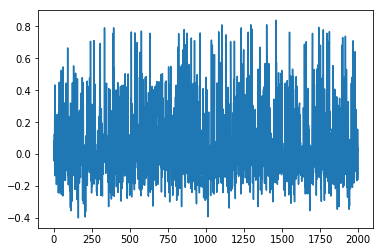

In [23]:
plt.plot(reward_list)

In [24]:
sum(reward_list)/1000

0.08960974805617507

/home/btphan/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


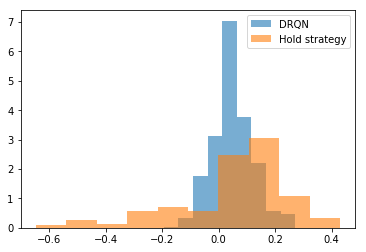

In [25]:
plt.hist(profit_list, alpha = 0.6, normed= True, label = 'DRQN')
plt.hist(hold_list, alpha = 0.6, normed= True, label = 'Hold strategy')
plt.legend()

In [144]:
trials = 300
trial_len = 252
reward_list = []
profit_list_eval = []
hold_list_eval = []
env = ENV()
for trial in range(trials):
    
    cur_state = env.reset()
    cur_state = cur_state.reshape(1,1,17)
    
    cum_reward = 0
    act_list = []
    random_action *= 0.95**(trial)
    
    hidden_agent = agent.initHidden()
    hidden_target = agent.initHidden()
    
    state_list = torch.Tensor()
    state_list = torch.cat((state_list,inputTensor(cur_state) ), 0 )
    cum_reward = 0
    #state_list.append(inputTensor(cur_state))
    target_list = torch.Tensor()
    act_list = []
    #data collection step
    for step in range(trial_len):
        #print dqn_agent.model.get_weights()[0][0]
        q_action, hidden = sample(cur_state, hidden_agent)
        q_action_target, hidden = sample_target(cur_state, hidden_target)
        
        
        action = sample_action(q_action)
        new_state, reward, done = env.step(action)
        
        q_action_target[0][action] = q_action_target[0][action] + 0.95*reward
        
        #target_list.append(q_action_target)
        cur_state = new_state
        cur_state = cur_state.reshape(1,1,17)
        
        target_list = torch.cat((target_list, q_action_target), 0)
        state_list = torch.cat((state_list,inputTensor(cur_state) ), 0 )
        act_list.append(action)
        cum_reward += reward
        if done == True:
            break
    reward_list.append(cum_reward)
    #print reward_list[-1]
    #print q_action
    profit_list_eval.append(env.ac_profit)
    hold_list_eval.append(np.log(env.eps[-1,-1]/env.eps[0,-1]))
    target_list = torch.cat((target_list, q_action_target), 0)
    
    #train(state_list, target_list)
    print 'Eps: ', trial
    print 'Q(s,a) =  ...', q_action
    print 'Reward = ', reward_list[-1]
    print 'CASH: ',act_list.count(0)
    print 'STOCK: ',act_list.count(1)
    print 'Profit = ', env.ac_profit
    print 'Hold profit = ', np.log(env.eps[-1,-1]/env.eps[0,-1])
    print '---------------'
    
    if trial+1 %3 == 0:
        target_agent = copy.deepcopy(agent)


Eps:  0
Q(s,a) =  ... tensor([[-0.6890, -4.1172]])
Reward =  0.032382966321485046
CASH:  218
STOCK:  33
Profit =  0.024896460217806192
Hold profit =  0.010636814791881753
---------------
Eps:  1
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 1.2946, -3.0429]])
Reward =  -0.16982062339732498
CASH:  221
STOCK:  30
Profit =  -0.010219122937216212
Hold profit =  0.15067378104994403
---------------
Eps:  2
Q(s,a) =  ... tensor([[-0.1469, -0.4205]])
Reward =  -0.1656860492307574
CASH:  221
STOCK:  30
Profit =  0.005956795101014354
Hold profit =  0.16730946343572065
---------------
Eps:  3
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 8.5209, -6.3988]])
Reward =  0.3017322016182859
CASH:  208
STOCK:  43
Profit =  0.04862451406700486
Hold profit =  -0.20358100431747478
---------------
Eps:  4
Q(s,a) =  ... tensor([[-0.1537, -0.2433]])
Reward =  -0.010004957220676309
CASH:  222
STOCK:  29
Profit =  0.027466974486516908
Hold profit =  0.06436272811610402
---------------
Eps:  5
Q(s,a) =  ... tensor

Eps:  44
Q(s,a) =  ... tensor([[ 0.0548,  0.1401]])
Reward =  -0.008364880944183951
CASH:  220
STOCK:  31
Profit =  0.06646860540981928
Hold profit =  0.12010979272874818
---------------
Eps:  45
Q(s,a) =  ... tensor([[-0.1215, -0.7380]])
Reward =  -0.1416627321542824
CASH:  210
STOCK:  41
Profit =  -0.01701974705536719
Hold profit =  0.11935981191975095
---------------
Eps:  46
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 1.2946, -3.0429]])
Reward =  -0.16982062339732498
CASH:  221
STOCK:  30
Profit =  -0.010219122937216212
Hold profit =  0.15067378104994403
---------------
Eps:  47
Q(s,a) =  ... tensor([[-0.0384, -0.2255]])
Reward =  0.017802005013687477
CASH:  211
STOCK:  40
Profit =  -0.09681113311824192
Hold profit =  -0.19718595862718458
---------------
Eps:  48
Q(s,a) =  ... tensor([[-0.2646, -1.8314]])
Reward =  0.09790149836325093
CASH:  211
STOCK:  40
Profit =  0.15038002071837758
Hold profit =  0.2141334293381289
---------------
Eps:  49
Q(s,a) =  ... tensor([[-0.0530, -0.52

Eps:  88
Q(s,a) =  ... tensor([[ 0.0651,  0.1726]])
Reward =  0.31852358212579945
CASH:  216
STOCK:  35
Profit =  0.2458817954915431
Hold profit =  0.1731760169803611
---------------
Eps:  89
Q(s,a) =  ... tensor([[ 0.0003, -0.1609]])
Reward =  -0.2102127681641899
CASH:  221
STOCK:  30
Profit =  0.013602879039324974
Hold profit =  0.23525718664745882
---------------
Eps:  90
Q(s,a) =  ... tensor([[-0.0239, -0.1962]])
Reward =  -0.07782495524170077
CASH:  223
STOCK:  28
Profit =  0.02268249340421108
Hold profit =  0.13465896002116953
---------------
Eps:  91
Q(s,a) =  ... tensor([[-0.1651, -0.4141]])
Reward =  -0.013923219240546484
CASH:  203
STOCK:  48
Profit =  0.015156688908719466
Hold profit =  0.0322993790998472
---------------
Eps:  92
Q(s,a) =  ... tensor([[ 0.0074, -0.1501]])
Reward =  -0.15989293478886205
CASH:  214
STOCK:  37
Profit =  -0.02705844983549057
Hold profit =  0.11120187743881141
---------------
Eps:  93
Q(s,a) =  ... tensor([[-0.0149, -0.1863]])
Reward =  0.4219063

Eps:  133
Q(s,a) =  ... tensor([[-0.0488, -0.3471]])
Reward =  -0.07600106526051893
CASH:  204
STOCK:  47
Profit =  0.02117678901821971
Hold profit =  0.11347313078833246
---------------
Eps:  134
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-4.3365, -8.3270]])
Reward =  0.14758949155510723
CASH:  197
STOCK:  54
Profit =  -0.06549075991136533
Hold profit =  -0.271030458253759
---------------
Eps:  135
Q(s,a) =  ... tensor([[-0.0150, -0.2410]])
Reward =  0.13262244399278747
CASH:  213
STOCK:  38
Profit =  0.09404593640421643
Hold profit =  0.0532490814655273
---------------
Eps:  136
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-2.4189, -8.3084]])
Reward =  0.09835006911571244
CASH:  219
STOCK:  32
Profit =  0.21546953098952457
Hold profit =  0.33915215038396807
---------------
Eps:  137
Q(s,a) =  ... tensor([[-0.0878, -0.3064]])
Reward =  -0.05308868957383428
CASH:  207
STOCK:  44
Profit =  0.07264002502096983
Hold profit =  0.20346984281813454
---------------
Eps:  138
Q(s,a) =  ... ten

Eps:  177
Q(s,a) =  ... tensor([[ 0.1063,  0.0921]])
Reward =  0.33169518550720556
CASH:  216
STOCK:  35
Profit =  0.22135446270623804
Hold profit =  0.08254771182771845
---------------
Eps:  178
Q(s,a) =  ... tensor([[-0.0653, -0.2277]])
Reward =  -0.008797441376367813
CASH:  217
STOCK:  34
Profit =  0.023501080202078622
Hold profit =  0.05120902315690966
---------------
Eps:  179
Q(s,a) =  ... tensor([[-0.0861, -0.1159]])
Reward =  -0.36071384679756613
CASH:  225
STOCK:  26
Profit =  -0.041655721302402
Hold profit =  0.27490811094473155
---------------
Eps:  180
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 3.0521,  3.9541]])
Reward =  0.5432602574562063
CASH:  192
STOCK:  59
Profit =  0.016285495285855427
Hold profit =  -0.5340782110321405
---------------
Eps:  181
Q(s,a) =  ... tensor([[-0.1361, -0.4109]])
Reward =  -0.15244796072044584
CASH:  223
STOCK:  28
Profit =  0.00892066513326982
Hold profit =  0.1697849778479811
---------------
Eps:  182
Q(s,a) =  ... tensor(1.00000e-02 *
 

Eps:  221
Q(s,a) =  ... tensor([[-0.0438, -0.2753]])
Reward =  -0.07616300476103849
CASH:  220
STOCK:  31
Profit =  0.02304526050454269
Hold profit =  0.12961093575362526
---------------
Eps:  222
Q(s,a) =  ... tensor([[-0.0476, -0.3457]])
Reward =  0.016934210791186163
CASH:  214
STOCK:  37
Profit =  0.08729196141486051
Hold profit =  0.1640110210321295
---------------
Eps:  223
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 0.4400, -7.7234]])
Reward =  0.10444607694630456
CASH:  212
STOCK:  39
Profit =  0.10042146292067017
Hold profit =  0.08669979834329002
---------------
Eps:  224
Q(s,a) =  ... tensor([[-0.1637, -0.3446]])
Reward =  -0.04766582844969901
CASH:  219
STOCK:  32
Profit =  0.058673170753026506
Hold profit =  0.16536604482965053
---------------
Eps:  225
Q(s,a) =  ... tensor([[-0.0217, -0.1970]])
Reward =  -0.04606757550584342
CASH:  202
STOCK:  49
Profit =  0.017061611987239354
Hold profit =  0.08767618965653434
---------------
Eps:  226
Q(s,a) =  ... tensor([[-0.0245, -0

Eps:  265
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-6.8891, -1.9607]])
Reward =  0.583521934015294
CASH:  198
STOCK:  53
Profit =  0.01164929220358251
Hold profit =  -0.5925031393570582
---------------
Eps:  266
Q(s,a) =  ... tensor([[ 0.2945,  0.2306]])
Reward =  0.011342731547678751
CASH:  207
STOCK:  44
Profit =  0.06960911497745209
Hold profit =  0.13835506227679664
---------------
Eps:  267
Q(s,a) =  ... tensor([[-0.0653, -0.6037]])
Reward =  -0.07763618233641753
CASH:  216
STOCK:  35
Profit =  0.05471808428553581
Hold profit =  0.1808650959497791
---------------
Eps:  268
Q(s,a) =  ... tensor([[-1.1709, -6.9507]])
Reward =  -0.3000890433660454
CASH:  215
STOCK:  36
Profit =  -0.032739201232631236
Hold profit =  0.23086760693773475
---------------
Eps:  269
Q(s,a) =  ... tensor([[ 0.0345, -0.2309]])
Reward =  0.17092721982698017
CASH:  212
STOCK:  39
Profit =  0.014247500066263165
Hold profit =  -0.13446242235147998
---------------
Eps:  270
Q(s,a) =  ... tensor([[-0.0456, -0.1

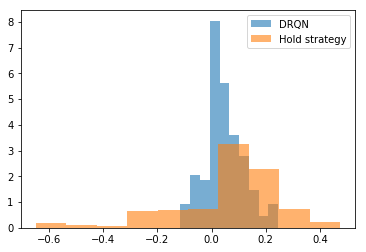

In [145]:
plt.hist(profit_list_eval, alpha = 0.6, normed= True, label = 'DRQN')
plt.hist(hold_list_eval, alpha = 0.6, normed= True, label = 'Hold strategy')
plt.legend()

In [146]:
dqn = np.loadtxt('DQN')

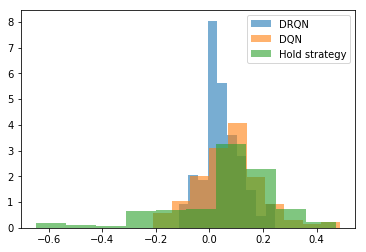

In [147]:
plt.hist(profit_list_eval, alpha = 0.6, normed= True, label = 'DRQN')
plt.hist(dqn, alpha = 0.6, normed= True, label = 'DQN')
plt.hist(hold_list_eval, alpha = 0.6, normed= True, label = 'Hold strategy')
plt.legend()

Text(0.5,0,'profit')

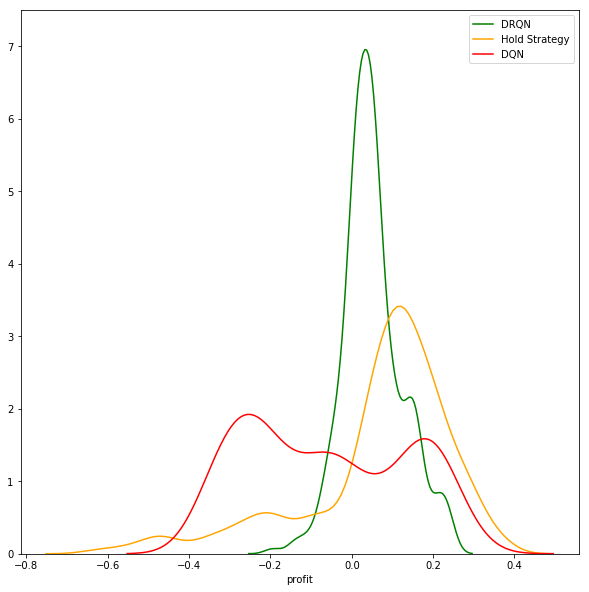

In [139]:
plt.figure(figsize=(10,10))
plt.ylim([0, 7.5])
sns.distplot(profit_list_eval, hist= False, color= 'green', label='DRQN')
sns.distplot(hold_list_eval, hist= False, color= 'orange', label= 'Hold Strategy')
sns.distplot(dqn_eval, hist= False, color= 'red', label='DQN')
plt.xlabel('profit')

In [140]:
dqn.mean()

0.07348420022706477

In [143]:
sum(hold_list_eval)/300

0.06336724790451191

In [141]:
profit_list_eval = np.array(profit_list_eval)
print np.mean(profit_list_eval)
print profit_list_eval.std()

0.051605626385485326
0.07251886656306462


In [31]:
df_val = pd.read_csv('TM.csv')[750:1750].reset_index(drop= True)
df_val['Adj Close'] = df_val['Adj Close']/ df_val['Adj Close'].values[0]
df_val = indicator.moving_average(df_val, 20)
df_val = indicator.moving_average(df_val, 40)
#df = indicator.moving_average(df, 60)
#df = indicator.moving_average(df, 80)
#df = indicator.moving_average(df, 100)

df_val = indicator.exponential_moving_average(df_val, 20)
df_val = indicator.exponential_moving_average(df_val, 40)
df_val['adj/sma20'] = df_val['Adj Close']/df_val['MA_20']
df_val['adj/sma40'] = df_val['Adj Close']/df_val['MA_40']
df_val['adj/ema20'] = df_val['Adj Close']/df_val['EMA_20']
df_val['adj/ema40'] = df_val['Adj Close']/df_val['EMA_40']
df_val = indicator.bollinger_bands(df_val, 20)
df_val = indicator.bollinger_bands(df_val, 40)
df_val = indicator.relative_strength_index(df_val, 20)
df_val = indicator.relative_strength_index(df_val, 40)
df_val = indicator.momentum(df_val,20)
df_val = indicator.momentum(df_val, 40)
df_val = indicator.accumulation_distribution(df_val,40)
df_val = indicator.accumulation_distribution(df_val,20)
df_val['price'] = df_val['Adj Close']


df_val = df_val[df_val.index > 101]
val_data = df_val.values[:,11:]

In [32]:
class ENV_eval():
    CASH = 0
    STOCK = 1
    def __init__(self):    
        self.position = self.CASH
        self.state = None
        self.eps = None
        self.entry = None
        self.done = None
        self.pointer = None
        self.train_profit = None
        self.train_df1 = train_data
        self.val_df1 = val_data
        self.ac_profit = None
        
    def reset(self):
        self.position = self.CASH
        self.ac_profit = 0
        self.state = None
        self.eps = None
        self.entry = None
        self.done = False
        self.pointer = 0
        self.train_profit = 0
        partition = random.randint(0,len(self.val_df1) - 252 - 1)
        self.eps = self.val_df1[partition:partition+252+1]
        self.state = np.append(np.append(self.eps[self.pointer,:-1], keras.utils.to_categorical(self.position, 2)), self.train_profit)
        #self.state = self.eps[self.pointer,:]
        return self.state
        
    def step(self,action):
        self.pointer += 1 #move to next day
        #print pre_position, action, self.LONG
        fee = 0
        reward = 0
        if self.position == self.CASH and action == self.STOCK:
            self.position = self.STOCK
            self.entry = self.pointer - 1  #Enter the market
        elif self.position == self.STOCK and action == self.CASH:
            self.position = self.CASH
            #self.entry = None
        reward = 0
        if self.position == self.CASH:
            reward = -0.25*np.log(self.eps[self.pointer,-1]/self.eps[self.pointer-1, -1]) 
            self.train_profit = 0
        elif self.position == self.STOCK:
            reward = 1.0*np.log(self.eps[self.pointer,-1]/self.eps[self.pointer-1, -1]) 
            self.train_profit += np.log(self.eps[self.pointer,-1]/self.eps[self.pointer-1, -1]) 
            self.ac_profit += np.log(self.eps[self.pointer,-1]/self.eps[self.pointer-1, -1]) 
        
        if self.pointer == 251:
            self.done = True
        self.state = np.append(np.append(self.eps[self.pointer,:-1], keras.utils.to_categorical(self.position, 2)), self.train_profit)
        #self.state = self.eps[self.pointer,:]
        return self.state, reward, self.done

In [33]:
trials = 300
env = ENV_eval()
trial_len = 252
reward_list = []
profit_list_eval = []
hold_list_eval = []
for trial in range(trials):
    
    cur_state = env.reset()
    cur_state = cur_state.reshape(1,1,17)
    
    cum_reward = 0
    act_list = []
    random_action *= 0.95**(trial)
    
    hidden_agent = agent.initHidden()
    hidden_target = agent.initHidden()
    
    state_list = torch.Tensor()
    state_list = torch.cat((state_list,inputTensor(cur_state) ), 0 )
    cum_reward = 0
    #state_list.append(inputTensor(cur_state))
    target_list = torch.Tensor()
    act_list = []
    #data collection step
    for step in range(trial_len):
        #print dqn_agent.model.get_weights()[0][0]
        q_action, hidden = sample(cur_state, hidden_agent)
        q_action_target, hidden = sample_target(cur_state, hidden_target)
        
        
        action = sample_action(q_action)
        new_state, reward, done = env.step(action)
        
        q_action_target[0][action] = q_action_target[0][action] + 0.95*reward
        
        #target_list.append(q_action_target)
        cur_state = new_state
        cur_state = cur_state.reshape(1,1,17)
        
        target_list = torch.cat((target_list, q_action_target), 0)
        state_list = torch.cat((state_list,inputTensor(cur_state) ), 0 )
        act_list.append(action)
        cum_reward += reward
        if done == True:
            break
    reward_list.append(cum_reward)
    #print reward_list[-1]
    #print q_action
    profit_list_eval.append(env.ac_profit)
    hold_list_eval.append(np.log(env.eps[-1,-1]/env.eps[0,-1]))
    target_list = torch.cat((target_list, q_action_target), 0)
    
    #train(state_list, target_list)
    print 'Eps: ', trial
    print 'Q(s,a) =  ...', q_action
    print 'Reward = ', reward_list[-1]
    print 'CASH: ',act_list.count(0)
    print 'STOCK: ',act_list.count(1)
    print 'Profit = ', env.ac_profit
    print 'Hold profit = ', np.log(env.eps[-1,-1]/env.eps[0,-1])
    print '---------------'
    
    if trial+1 %3 == 0:
        target_agent = copy.deepcopy(agent)


Eps:  0
Q(s,a) =  ... tensor([[ 0.0934,  0.3088]])
Reward =  0.12520091968646685
CASH:  212
STOCK:  39
Profit =  0.12207377535801407
Hold profit =  0.11494599080883254
---------------
Eps:  1
Q(s,a) =  ... tensor([[ 0.0162, -0.1634]])
Reward =  -0.06696542522116497
CASH:  212
STOCK:  39
Profit =  -0.04356797253761727
Hold profit =  0.0645960013751091
---------------
Eps:  2
Q(s,a) =  ... tensor([[-0.0161, -0.2207]])
Reward =  0.3432640734789039
CASH:  215
STOCK:  36
Profit =  0.29991247414537753
Hold profit =  0.129589120411429
---------------
Eps:  3
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 2.4523,  0.6262]])
Reward =  -0.06285234279718692
CASH:  210
STOCK:  41
Profit =  -0.04460865944588818
Hold profit =  0.01275464774389175
---------------
Eps:  4
Q(s,a) =  ... tensor([[ 0.2251,  1.4720]])
Reward =  -0.021114714737965674
CASH:  224
STOCK:  27
Profit =  0.037415793743041256
Hold profit =  0.25345447404069044
---------------
Eps:  5
Q(s,a) =  ... tensor([[-0.0167, -0.1066]])
Rewar

Eps:  44
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 2.0853, -4.1217]])
Reward =  0.2501846217185482
CASH:  208
STOCK:  43
Profit =  0.1988444899807474
Hold profit =  -0.0059089222506805
---------------
Eps:  45
Q(s,a) =  ... tensor([[ 0.0276, -0.1242]])
Reward =  0.12304681266700512
CASH:  212
STOCK:  39
Profit =  0.10984717927226054
Hold profit =  0.06374078862456775
---------------
Eps:  46
Q(s,a) =  ... tensor([[-0.0089, -0.1853]])
Reward =  0.09804437306559362
CASH:  200
STOCK:  51
Profit =  0.04803798799652219
Hold profit =  -0.15602132224047424
---------------
Eps:  47
Q(s,a) =  ... tensor([[-0.0136, -0.1722]])
Reward =  0.09659392869372306
CASH:  205
STOCK:  46
Profit =  0.09260454078222044
Hold profit =  0.07617970479411067
---------------
Eps:  48
Q(s,a) =  ... tensor([[ 0.0027, -0.1435]])
Reward =  0.003466711261601
CASH:  215
STOCK:  36
Profit =  0.015408963064220519
Hold profit =  0.0574669201899226
---------------
Eps:  49
Q(s,a) =  ... tensor([[-0.3415, -2.3995]])
Rewar

Eps:  88
Q(s,a) =  ... tensor([[-0.0227, -0.1495]])
Reward =  0.2767625839134371
CASH:  207
STOCK:  44
Profit =  0.22319760560652616
Hold profit =  0.0007798548007870299
---------------
Eps:  89
Q(s,a) =  ... tensor([[ 0.0934,  0.3088]])
Reward =  0.12520091968646685
CASH:  212
STOCK:  39
Profit =  0.12207377535801407
Hold profit =  0.11494599080883254
---------------
Eps:  90
Q(s,a) =  ... tensor([[ 0.4166,  0.6297]])
Reward =  0.25340131190130244
CASH:  207
STOCK:  44
Profit =  0.19971153538323164
Hold profit =  -0.018345053026316935
---------------
Eps:  91
Q(s,a) =  ... tensor([[-0.0211, -0.1869]])
Reward =  -0.019482745149438607
CASH:  225
STOCK:  26
Profit =  0.036701441405183624
Hold profit =  0.2681770151566257
---------------
Eps:  92
Q(s,a) =  ... tensor([[-0.0003, -0.1728]])
Reward =  0.03567547277544506
CASH:  214
STOCK:  37
Profit =  0.02482561691559606
Hold profit =  -0.007373299840137576
---------------
Eps:  93
Q(s,a) =  ... tensor([[-0.0000, -0.1049]])
Reward =  0.1050

Eps:  132
Q(s,a) =  ... tensor(1.00000e+12 *
       [[-0.1653, -1.0501]])
Reward =  0.27826193136335653
CASH:  207
STOCK:  44
Profit =  0.22319760560652616
Hold profit =  0.004306435619489656
---------------
Eps:  133
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-1.9146, -7.1030]])
Reward =  -0.044826432379143084
CASH:  203
STOCK:  48
Profit =  -0.07683907972074329
Hold profit =  -0.22089589881062102
---------------
Eps:  134
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-4.9564, -7.9825]])
Reward =  -0.0019685628013390547
CASH:  223
STOCK:  28
Profit =  0.03180390441638476
Hold profit =  0.16297175534152744
---------------
Eps:  135
Q(s,a) =  ... tensor([[  4365.9747,  27736.0950]])
Reward =  0.006049359231582413
CASH:  222
STOCK:  29
Profit =  0.028170817136671703
Hold profit =  0.11027405176473737
---------------
Eps:  136
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 3.8163, -3.8094]])
Reward =  0.07603885842468505
CASH:  217
STOCK:  34
Profit =  0.11155924035285406
Hold profit =  0.26

Eps:  174
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-1.4885, -7.6053]])
Reward =  0.2581406418468909
CASH:  207
STOCK:  44
Profit =  0.19971153538323164
Hold profit =  -0.03244454862683844
---------------
Eps:  175
Q(s,a) =  ... tensor([[ 0.0701,  0.2588]])
Reward =  -0.015556250406043047
CASH:  224
STOCK:  27
Profit =  0.042133324851905476
Hold profit =  0.27505648953136275
---------------
Eps:  176
Q(s,a) =  ... tensor([[ 0.9451,  6.2747]])
Reward =  0.3460004651792862
CASH:  214
STOCK:  37
Profit =  0.2996701807945877
Hold profit =  0.12830339045820097
---------------
Eps:  177
Q(s,a) =  ... tensor([[ 0.4513,  0.5977]])
Reward =  -0.05606260804130288
CASH:  213
STOCK:  38
Profit =  -0.04224586471744597
Hold profit =  0.011699000757808877
---------------
Eps:  178
Q(s,a) =  ... tensor([[-0.0427, -0.1959]])
Reward =  0.2679980565204905
CASH:  206
STOCK:  45
Profit =  0.214130704705301
Hold profit =  -0.0026128731453825683
---------------
Eps:  179
Q(s,a) =  ... tensor([[ 0.1597,  0.

Eps:  218
Q(s,a) =  ... tensor([[-0.0274, -0.1860]])
Reward =  0.1300205772419479
CASH:  196
STOCK:  55
Profit =  0.06906148735671229
Hold profit =  -0.17325929397103315
---------------
Eps:  219
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-7.0729, -3.7337]])
Reward =  -0.05692810615763033
CASH:  212
STOCK:  39
Profit =  -0.04356797253761727
Hold profit =  0.04854351397265276
---------------
Eps:  220
Q(s,a) =  ... tensor([[ 0.0170, -0.1941]])
Reward =  0.08021878618747315
CASH:  216
STOCK:  35
Profit =  0.10376479523883869
Hold profit =  0.19743731908211737
---------------
Eps:  221
Q(s,a) =  ... tensor([[-0.2745,  0.0505]])
Reward =  0.015367629773376107
CASH:  209
STOCK:  42
Profit =  -0.013313016593149783
Hold profit =  -0.08530720644259537
---------------
Eps:  222
Q(s,a) =  ... tensor([[-0.0170, -0.1396]])
Reward =  0.21680495294301824
CASH:  208
STOCK:  43
Profit =  0.1864270072676143
Hold profit =  0.07905707399845678
---------------
Eps:  223
Q(s,a) =  ... tensor(1.00000e-02 *

Eps:  262
Q(s,a) =  ... tensor([[-0.0573, -0.2153]])
Reward =  0.09792023803014603
CASH:  196
STOCK:  55
Profit =  0.022254183326136344
Hold profit =  -0.2740551835005173
---------------
Eps:  263
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-3.2923, -8.5108]])
Reward =  -0.04460048832390998
CASH:  203
STOCK:  48
Profit =  -0.07683907972074329
Hold profit =  -0.20173813199670346
---------------
Eps:  264
Q(s,a) =  ... tensor([[-0.0356, -0.1669]])
Reward =  -0.05351965610960048
CASH:  213
STOCK:  38
Profit =  -0.029499994309664053
Hold profit =  0.07966264326266422
---------------
Eps:  265
Q(s,a) =  ... tensor([[-0.0329, -0.3017]])
Reward =  0.25669152027472564
CASH:  207
STOCK:  44
Profit =  0.21192848035333092
Hold profit =  0.03347961559919745
---------------
Eps:  266
Q(s,a) =  ... tensor([[ 0.0066, -0.1149]])
Reward =  0.21707279906412807
CASH:  209
STOCK:  42
Profit =  0.18419331089175645
Hold profit =  0.05490905457812936
---------------
Eps:  267
Q(s,a) =  ... tensor([[-0.0034, 

(array([0.82044739, 1.31271582, 0.65635791, 0.16408948, 2.13316321,
        3.55527202, 4.81329135, 1.31271582, 0.87514388, 0.7657509 ]),
 array([-0.3018138 , -0.24087144, -0.17992909, -0.11898673, -0.05804437,
         0.00289799,  0.06384035,  0.12478271,  0.18572507,  0.24666743,
         0.30760979]),
 <a list of 10 Patch objects>)

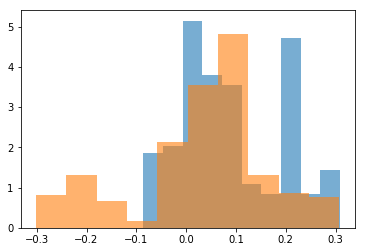

In [34]:
plt.hist(profit_list_eval, alpha = 0.6, normed= True, label = 'DRQN')
plt.hist(hold_list_eval, alpha = 0.6, normed= True, label = 'Hold strategy')


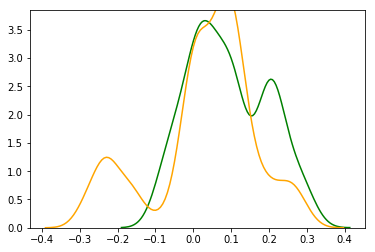

In [35]:
sns.distplot(profit_list_eval, hist= False, color= 'green')
sns.distplot(hold_list_eval, hist= False, color= 'orange')

In [36]:
sum(profit_list_eval)/300

0.09192231356315947

In [37]:
sum(hold_list_eval)/300

0.03039389079372259

In [38]:
profit_list_eval = np.array(profit_list_eval)
print profit_list_eval.std()

0.10235864314751561


In [39]:
hold_list_eval = np.array(hold_list_eval)
print hold_list_eval.std()

0.13542008713039422


In [2]:
import numpy as np
dqn_eval = np.loadtxt('DQN_eval')

In [6]:
dqn_eval.std()

0.19404623400469911

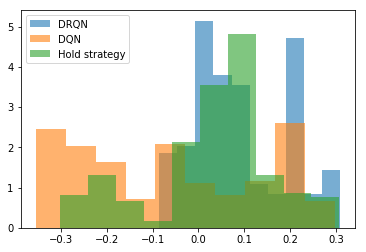

In [41]:
plt.hist(profit_list_eval, alpha = 0.6, normed= True, label = 'DRQN')
plt.hist(dqn_eval, alpha = 0.6, normed= True, label = 'DQN')
plt.hist(hold_list_eval, alpha = 0.6, normed= True, label = 'Hold strategy')
plt.legend()

Text(0.5,0,'profit')

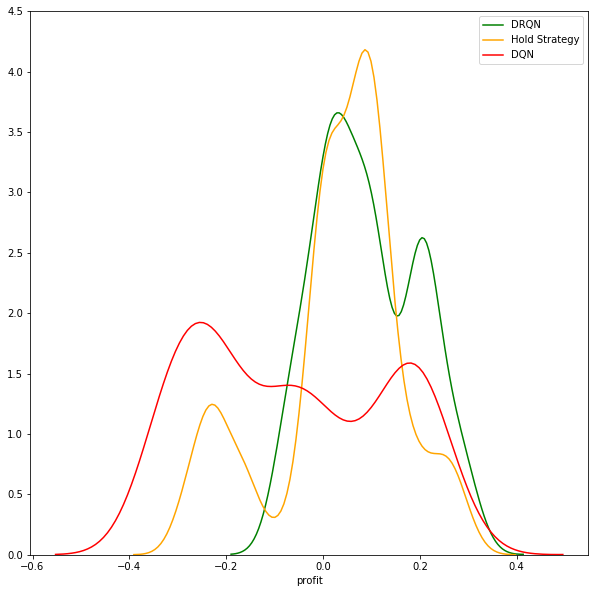

In [125]:
plt.figure(figsize=(10,10))
plt.ylim([0, 4.5])
sns.distplot(profit_list_eval, hist= False, color= 'green', label='DRQN')
sns.distplot(hold_list_eval, hist= False, color= 'orange', label= 'Hold Strategy')
sns.distplot(dqn_eval, hist= False, color= 'red', label='DQN')
plt.xlabel('profit')

In [50]:
profit_list_eval.mean()

0.09192231356315944

In [51]:
profit_list_eval.std()

0.10235864314751561

In [52]:
hold_list_eval.mean()

0.030393890793722598

In [53]:
hold_list_eval.std()

0.13542008713039422

In [54]:
dqn_eval.mean()

-0.062566889494568

In [55]:
dqn_eval.std()

0.19404623400469911

In [91]:
trials = 1
env = ENV_eval()
trial_len = 252
reward_list = []
profit_list_eval_demo = []
hold_list_eval_demo = []

for trial in range(trials):
    
    cur_state = env.reset()
    cur_state = cur_state.reshape(1,1,17)
    
    cum_reward = 0
    act_list = []
    random_action *= 0.95**(trial)
    
    hidden_agent = agent.initHidden()
    hidden_target = agent.initHidden()
    
    state_list = torch.Tensor()
    state_list = torch.cat((state_list,inputTensor(cur_state) ), 0 )
    cum_reward = 0
    #state_list.append(inputTensor(cur_state))
    target_list = torch.Tensor()
    act_list = []
    #data collection step
    for step in range(trial_len):
        #print dqn_agent.model.get_weights()[0][0]
        q_action, hidden = sample(cur_state, hidden_agent)
        q_action_target, hidden = sample_target(cur_state, hidden_target)
        
        
        action = sample_action(q_action)
        new_state, reward, done = env.step(action)
        
        q_action_target[0][action] = q_action_target[0][action] + 0.95*reward
        
        #target_list.append(q_action_target)
        cur_state = new_state
        cur_state = cur_state.reshape(1,1,17)
        
        target_list = torch.cat((target_list, q_action_target), 0)
        state_list = torch.cat((state_list,inputTensor(cur_state) ), 0 )
        act_list.append(action)
        cum_reward += reward
        if done == True:
            break
    reward_list.append(cum_reward)
    #print reward_list[-1]
    #print q_action
    profit_list_eval_demo.append(env.ac_profit)
    hold_list_eval_demo.append(np.log(env.eps[-1,-1]/env.eps[0,-1]))
    target_list = torch.cat((target_list, q_action_target), 0)
    
    #train(state_list, target_list)
    print 'Eps: ', trial
    print 'Q(s,a) =  ...', q_action
    print 'Reward = ', reward_list[-1]
    print 'CASH: ',act_list.count(0)
    print 'STOCK: ',act_list.count(1)
    print 'Profit = ', env.ac_profit
    print 'Hold profit = ', np.log(env.eps[-1,-1]/env.eps[0,-1])
    print '---------------'
    
    if trial+1 %3 == 0:
        target_agent = copy.deepcopy(agent)


Eps:  0
Q(s,a) =  ... tensor([[-0.0660, -0.3102]])
Reward =  0.32231725558585855
CASH:  215
STOCK:  36
Profit =  0.27351384247538557
Hold profit =  0.07326018162942859
---------------


In [92]:
act_list

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,


In [93]:
act_list.append(0)

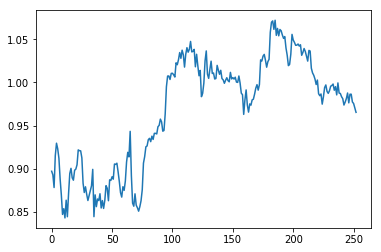

In [94]:
plt.plot(env.eps[:,-1])

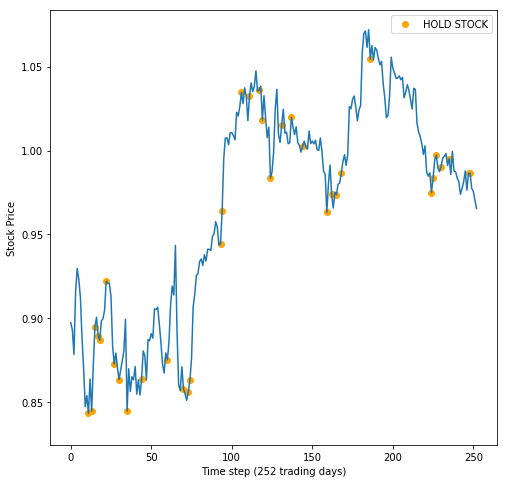

In [104]:
plt.figure(figsize=(8,8))
pts = env.eps[:-1,-1]*act_list
pos = np.where(pts>0)
pts = pts[pts>0]
#plt.figure(figsize=(40,30))
plt.scatter(pos, pts, color = 'orange', label ='HOLD STOCK')
plt.plot(env.eps[:,-1])
plt.legend()
plt.xlabel('Time step (252 trading days)')
plt.ylabel('Stock Price')
plt.show()

In [73]:
len(env.eps[:-1,-1])

252

In [109]:
trials = 1
env = ENV_eval()
trial_len = 252
reward_list = []
profit_list_eval_demo = []
hold_list_eval_demo = []

for trial in range(trials):
    
    cur_state = env.reset()
    cur_state = cur_state.reshape(1,1,17)
    
    cum_reward = 0
    act_list = []
    random_action *= 0.95**(trial)
    
    hidden_agent = agent.initHidden()
    hidden_target = agent.initHidden()
    
    state_list = torch.Tensor()
    state_list = torch.cat((state_list,inputTensor(cur_state) ), 0 )
    cum_reward = 0
    #state_list.append(inputTensor(cur_state))
    target_list = torch.Tensor()
    act_list = []
    #data collection step
    for step in range(trial_len):
        #print dqn_agent.model.get_weights()[0][0]
        q_action, hidden = sample(cur_state, hidden_agent)
        q_action_target, hidden = sample_target(cur_state, hidden_target)
        
        
        action = sample_action(q_action)
        new_state, reward, done = env.step(action)
        
        q_action_target[0][action] = q_action_target[0][action] + 0.95*reward
        
        #target_list.append(q_action_target)
        cur_state = new_state
        cur_state = cur_state.reshape(1,1,17)
        
        target_list = torch.cat((target_list, q_action_target), 0)
        state_list = torch.cat((state_list,inputTensor(cur_state) ), 0 )
        act_list.append(action)
        cum_reward += reward
        if done == True:
            break
    reward_list.append(cum_reward)
    #print reward_list[-1]
    #print q_action
    profit_list_eval_demo.append(env.ac_profit)
    hold_list_eval_demo.append(np.log(env.eps[-1,-1]/env.eps[0,-1]))
    target_list = torch.cat((target_list, q_action_target), 0)
    
    #train(state_list, target_list)
    print 'Eps: ', trial
    print 'Q(s,a) =  ...', q_action
    print 'Reward = ', reward_list[-1]
    print 'CASH: ',act_list.count(0)
    print 'STOCK: ',act_list.count(1)
    print 'Profit = ', env.ac_profit
    print 'Hold profit = ', np.log(env.eps[-1,-1]/env.eps[0,-1])
    print '---------------'
    
    if trial+1 %3 == 0:
        target_agent = copy.deepcopy(agent)


Eps:  0
Q(s,a) =  ... tensor([[-0.0236, -0.2030]])
Reward =  0.2700355706194435
CASH:  206
STOCK:  45
Profit =  0.214130704705301
Hold profit =  -0.007546447302232798
---------------


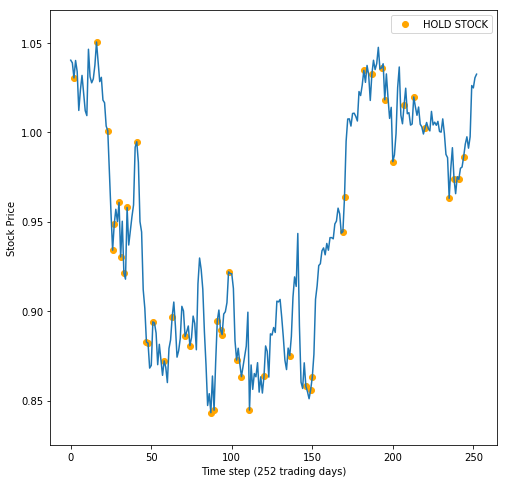

In [110]:
act_list.append(0)
plt.figure(figsize=(8,8))
pts = env.eps[:-1,-1]*act_list
pos = np.where(pts>0)
pts = pts[pts>0]
#plt.figure(figsize=(40,30))
plt.scatter(pos, pts, color = 'orange', label ='HOLD STOCK')
plt.plot(env.eps[:,-1])
plt.legend()
plt.xlabel('Time step (252 trading days)')
plt.ylabel('Stock Price')
plt.show()

In [112]:
trials = 1
env = ENV_eval()
trial_len = 252
reward_list = []
profit_list_eval_demo = []
hold_list_eval_demo = []

for trial in range(trials):
    
    cur_state = env.reset()
    cur_state = cur_state.reshape(1,1,17)
    
    cum_reward = 0
    act_list = []
    random_action *= 0.95**(trial)
    
    hidden_agent = agent.initHidden()
    hidden_target = agent.initHidden()
    
    state_list = torch.Tensor()
    state_list = torch.cat((state_list,inputTensor(cur_state) ), 0 )
    cum_reward = 0
    #state_list.append(inputTensor(cur_state))
    target_list = torch.Tensor()
    act_list = []
    #data collection step
    for step in range(trial_len):
        #print dqn_agent.model.get_weights()[0][0]
        q_action, hidden = sample(cur_state, hidden_agent)
        q_action_target, hidden = sample_target(cur_state, hidden_target)
        
        
        action = sample_action(q_action)
        new_state, reward, done = env.step(action)
        
        q_action_target[0][action] = q_action_target[0][action] + 0.95*reward
        
        #target_list.append(q_action_target)
        cur_state = new_state
        cur_state = cur_state.reshape(1,1,17)
        
        target_list = torch.cat((target_list, q_action_target), 0)
        state_list = torch.cat((state_list,inputTensor(cur_state) ), 0 )
        act_list.append(action)
        cum_reward += reward
        if done == True:
            break
    reward_list.append(cum_reward)
    #print reward_list[-1]
    #print q_action
    profit_list_eval_demo.append(env.ac_profit)
    hold_list_eval_demo.append(np.log(env.eps[-1,-1]/env.eps[0,-1]))
    target_list = torch.cat((target_list, q_action_target), 0)
    
    #train(state_list, target_list)
    print 'Eps: ', trial
    print 'Q(s,a) =  ...', q_action
    print 'Reward = ', reward_list[-1]
    print 'CASH: ',act_list.count(0)
    print 'STOCK: ',act_list.count(1)
    print 'Profit = ', env.ac_profit
    print 'Hold profit = ', np.log(env.eps[-1,-1]/env.eps[0,-1])
    print '---------------'
    
    if trial+1 %3 == 0:
        target_agent = copy.deepcopy(agent)


Eps:  0
Q(s,a) =  ... tensor([[-0.1109, -0.1782]])
Reward =  -0.051596831284088804
CASH:  205
STOCK:  46
Profit =  -0.08174354034780613
Hold profit =  -0.22244758973290032
---------------


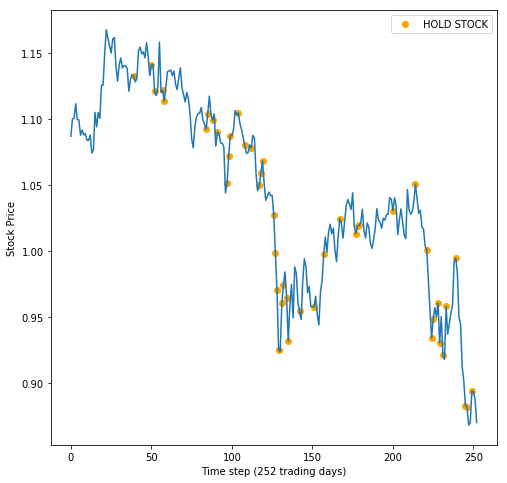

In [113]:
act_list.append(0)
plt.figure(figsize=(8,8))
pts = env.eps[:-1,-1]*act_list
pos = np.where(pts>0)
pts = pts[pts>0]
#plt.figure(figsize=(40,30))
plt.scatter(pos, pts, color = 'orange', label ='HOLD STOCK')
plt.plot(env.eps[:,-1])
plt.legend()
plt.xlabel('Time step (252 trading days)')
plt.ylabel('Stock Price')
plt.show()

In [117]:
trials = 1
env = ENV_eval()
trial_len = 252
reward_list = []
profit_list_eval_demo = []
hold_list_eval_demo = []

for trial in range(trials):
    
    cur_state = env.reset()
    cur_state = cur_state.reshape(1,1,17)
    
    cum_reward = 0
    act_list = []
    random_action *= 0.95**(trial)
    
    hidden_agent = agent.initHidden()
    hidden_target = agent.initHidden()
    
    state_list = torch.Tensor()
    state_list = torch.cat((state_list,inputTensor(cur_state) ), 0 )
    cum_reward = 0
    #state_list.append(inputTensor(cur_state))
    target_list = torch.Tensor()
    act_list = []
    #data collection step
    for step in range(trial_len):
        #print dqn_agent.model.get_weights()[0][0]
        q_action, hidden = sample(cur_state, hidden_agent)
        q_action_target, hidden = sample_target(cur_state, hidden_target)
        
        
        action = sample_action(q_action)
        new_state, reward, done = env.step(action)
        
        q_action_target[0][action] = q_action_target[0][action] + 0.95*reward
        
        #target_list.append(q_action_target)
        cur_state = new_state
        cur_state = cur_state.reshape(1,1,17)
        
        target_list = torch.cat((target_list, q_action_target), 0)
        state_list = torch.cat((state_list,inputTensor(cur_state) ), 0 )
        act_list.append(action)
        cum_reward += reward
        if done == True:
            break
    reward_list.append(cum_reward)
    #print reward_list[-1]
    #print q_action
    profit_list_eval_demo.append(env.ac_profit)
    hold_list_eval_demo.append(np.log(env.eps[-1,-1]/env.eps[0,-1]))
    target_list = torch.cat((target_list, q_action_target), 0)
    
    #train(state_list, target_list)
    print 'Eps: ', trial
    print 'Q(s,a) =  ...', q_action
    print 'Reward = ', reward_list[-1]
    print 'CASH: ',act_list.count(0)
    print 'STOCK: ',act_list.count(1)
    print 'Profit = ', env.ac_profit
    print 'Hold profit = ', np.log(env.eps[-1,-1]/env.eps[0,-1])
    print '---------------'
    
    if trial+1 %3 == 0:
        target_agent = copy.deepcopy(agent)


Eps:  0
Q(s,a) =  ... tensor([[-0.0765, -0.3422]])
Reward =  0.08129089851501493
CASH:  216
STOCK:  35
Profit =  0.10376479523883869
Hold profit =  0.20353997525453718
---------------


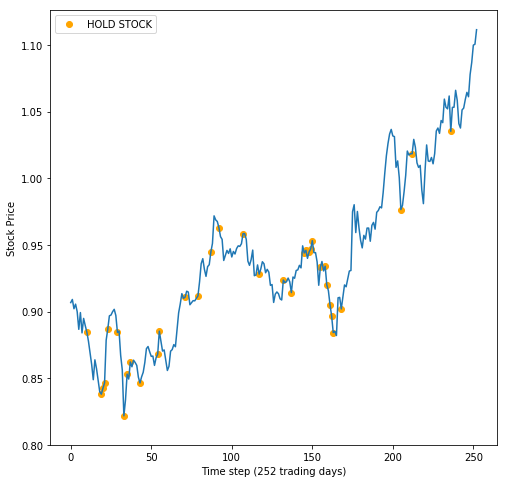

In [118]:
act_list.append(0)
plt.figure(figsize=(8,8))
pts = env.eps[:-1,-1]*act_list
pos = np.where(pts>0)
pts = pts[pts>0]
#plt.figure(figsize=(40,30))
plt.scatter(pos, pts, color = 'orange', label ='HOLD STOCK')
plt.plot(env.eps[:,-1])
plt.legend()
plt.xlabel('Time step (252 trading days)')
plt.ylabel('Stock Price')
plt.show()

In [120]:
df_val = pd.read_csv('^GSPC.csv')[4400:].reset_index(drop= True)
df_val['Adj Close'] = df_val['Adj Close']/ df_val['Adj Close'].values[0]
df_val = indicator.moving_average(df_val, 20)
df_val = indicator.moving_average(df_val, 40)
#df = indicator.moving_average(df, 60)
#df = indicator.moving_average(df, 80)
#df = indicator.moving_average(df, 100)

df_val = indicator.exponential_moving_average(df_val, 20)
df_val = indicator.exponential_moving_average(df_val, 40)
df_val['adj/sma20'] = df_val['Adj Close']/df_val['MA_20']
df_val['adj/sma40'] = df_val['Adj Close']/df_val['MA_40']
df_val['adj/ema20'] = df_val['Adj Close']/df_val['EMA_20']
df_val['adj/ema40'] = df_val['Adj Close']/df_val['EMA_40']
df_val = indicator.bollinger_bands(df_val, 20)
df_val = indicator.bollinger_bands(df_val, 40)
df_val = indicator.relative_strength_index(df_val, 20)
df_val = indicator.relative_strength_index(df_val, 40)
df_val = indicator.momentum(df_val,20)
df_val = indicator.momentum(df_val, 40)
df_val = indicator.accumulation_distribution(df_val,40)
df_val = indicator.accumulation_distribution(df_val,20)
df_val['price'] = df_val['Adj Close']


df_val = df_val[df_val.index > 101]
val_data = df_val.values[:,11:]

In [121]:
class ENV_eval():
    CASH = 0
    STOCK = 1
    def __init__(self):    
        self.position = self.CASH
        self.state = None
        self.eps = None
        self.entry = None
        self.done = None
        self.pointer = None
        self.train_profit = None
        self.train_df1 = train_data
        self.val_df1 = val_data
        self.ac_profit = None
        
    def reset(self):
        self.position = self.CASH
        self.ac_profit = 0
        self.state = None
        self.eps = None
        self.entry = None
        self.done = False
        self.pointer = 0
        self.train_profit = 0
        partition = random.randint(0,len(self.val_df1) - 252 - 1)
        self.eps = self.val_df1[partition:partition+252+1]
        self.state = np.append(np.append(self.eps[self.pointer,:-1], keras.utils.to_categorical(self.position, 2)), self.train_profit)
        #self.state = self.eps[self.pointer,:]
        return self.state
        
    def step(self,action):
        self.pointer += 1 #move to next day
        #print pre_position, action, self.LONG
        fee = 0
        reward = 0
        if self.position == self.CASH and action == self.STOCK:
            self.position = self.STOCK
            self.entry = self.pointer - 1  #Enter the market
        elif self.position == self.STOCK and action == self.CASH:
            self.position = self.CASH
            #self.entry = None
        reward = 0
        if self.position == self.CASH:
            reward = -0.25*np.log(self.eps[self.pointer,-1]/self.eps[self.pointer-1, -1]) 
            self.train_profit = 0
        elif self.position == self.STOCK:
            reward = 1.0*np.log(self.eps[self.pointer,-1]/self.eps[self.pointer-1, -1]) 
            self.train_profit += np.log(self.eps[self.pointer,-1]/self.eps[self.pointer-1, -1]) 
            self.ac_profit += np.log(self.eps[self.pointer,-1]/self.eps[self.pointer-1, -1]) 
        
        if self.pointer == 251:
            self.done = True
        self.state = np.append(np.append(self.eps[self.pointer,:-1], keras.utils.to_categorical(self.position, 2)), self.train_profit)
        #self.state = self.eps[self.pointer,:]
        return self.state, reward, self.done

In [122]:
trials = 300
env = ENV_eval()
trial_len = 252
reward_list = []
profit_list_eval_sp = []
hold_list_eval_sp = []
for trial in range(trials):
    
    cur_state = env.reset()
    cur_state = cur_state.reshape(1,1,17)
    
    cum_reward = 0
    act_list = []
    random_action *= 0.95**(trial)
    
    hidden_agent = agent.initHidden()
    hidden_target = agent.initHidden()
    
    state_list = torch.Tensor()
    state_list = torch.cat((state_list,inputTensor(cur_state) ), 0 )
    cum_reward = 0
    #state_list.append(inputTensor(cur_state))
    target_list = torch.Tensor()
    act_list = []
    #data collection step
    for step in range(trial_len):
        #print dqn_agent.model.get_weights()[0][0]
        q_action, hidden = sample(cur_state, hidden_agent)
        q_action_target, hidden = sample_target(cur_state, hidden_target)
        
        
        action = sample_action(q_action)
        new_state, reward, done = env.step(action)
        
        q_action_target[0][action] = q_action_target[0][action] + 0.95*reward
        
        #target_list.append(q_action_target)
        cur_state = new_state
        cur_state = cur_state.reshape(1,1,17)
        
        target_list = torch.cat((target_list, q_action_target), 0)
        state_list = torch.cat((state_list,inputTensor(cur_state) ), 0 )
        act_list.append(action)
        cum_reward += reward
        if done == True:
            break
    reward_list.append(cum_reward)
    #print reward_list[-1]
    #print q_action
    profit_list_eval_sp.append(env.ac_profit)
    hold_list_eval_sp.append(np.log(env.eps[-1,-1]/env.eps[0,-1]))
    target_list = torch.cat((target_list, q_action_target), 0)
    
    #train(state_list, target_list)
    print 'Eps: ', trial
    print 'Q(s,a) =  ...', q_action
    print 'Reward = ', reward_list[-1]
    print 'CASH: ',act_list.count(0)
    print 'STOCK: ',act_list.count(1)
    print 'Profit = ', env.ac_profit
    print 'Hold profit = ', np.log(env.eps[-1,-1]/env.eps[0,-1])
    print '---------------'
    
    if trial+1 %3 == 0:
        target_agent = copy.deepcopy(agent)


Eps:  0
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 5.7476, -2.8114]])
Reward =  -0.12928890129830226
CASH:  226
STOCK:  25
Profit =  -0.08045974582195754
Hold profit =  0.11792013700961163
---------------
Eps:  1
Q(s,a) =  ... tensor([[-0.0236, -0.1153]])
Reward =  -0.051681282365566183
CASH:  214
STOCK:  37
Profit =  -0.03135673166072583
Hold profit =  0.044149716462901424
---------------
Eps:  2
Q(s,a) =  ... tensor([[-0.0197, -0.1278]])
Reward =  -0.04319518781192296
CASH:  221
STOCK:  30
Profit =  -0.020563766969318994
Hold profit =  0.05743733853451565
---------------
Eps:  3
Q(s,a) =  ... tensor([[-0.1868, -1.1810]])
Reward =  -0.03321138824986432
CASH:  221
STOCK:  30
Profit =  -0.009401393373575968
Hold profit =  0.09740132194762158
---------------
Eps:  4
Q(s,a) =  ... tensor([[-0.0030, -0.1226]])
Reward =  -0.11220978198176329
CASH:  207
STOCK:  44
Profit =  -0.09972228692941656
Hold profit =  -0.048540212960778144
---------------
Eps:  5
Q(s,a) =  ... tensor([[-0.0321, -0.

Eps:  44
Q(s,a) =  ... tensor([[-0.0308, -0.2415]])
Reward =  -0.010892242100257124
CASH:  222
STOCK:  29
Profit =  0.02187530859322876
Hold profit =  0.1570258705524325
---------------
Eps:  45
Q(s,a) =  ... tensor([[ 0.0065, -0.1782]])
Reward =  -0.10272731821474843
CASH:  210
STOCK:  41
Profit =  -0.08155502261390155
Hold profit =  -0.0060833725705514655
---------------
Eps:  46
Q(s,a) =  ... tensor([[ 0.2449,  0.2048]])
Reward =  -0.07921851598630933
CASH:  218
STOCK:  33
Profit =  -0.0410101373848709
Hold profit =  0.1016428239368597
---------------
Eps:  47
Q(s,a) =  ... tensor([[ 0.0095, -0.2149]])
Reward =  -9.265436384213e-06
CASH:  228
STOCK:  23
Profit =  0.035295433386831804
Hold profit =  0.17749737956674366
---------------
Eps:  48
Q(s,a) =  ... tensor([[-0.0053, -0.1312]])
Reward =  -0.02938756727637449
CASH:  219
STOCK:  32
Profit =  -0.000995716032406068
Hold profit =  0.1254508592660602
---------------
Eps:  49
Q(s,a) =  ... tensor([[-0.0710, -0.2429]])
Reward =  -0.0

Eps:  88
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 0.7389, -2.1570]])
Reward =  -0.03581622368129598
CASH:  225
STOCK:  26
Profit =  0.011480141209521276
Hold profit =  0.199486021648336
---------------
Eps:  89
Q(s,a) =  ... tensor([[-0.0029, -0.1590]])
Reward =  -0.07749429676806534
CASH:  209
STOCK:  42
Profit =  -0.06199057761580638
Hold profit =  0.0063352580303928235
---------------
Eps:  90
Q(s,a) =  ... tensor([[-0.1286, -0.3754]])
Reward =  -0.12404042925119005
CASH:  227
STOCK:  24
Profit =  -0.07040564244241215
Hold profit =  0.14327726605006286
---------------
Eps:  91
Q(s,a) =  ... tensor([[ 0.0057,  0.3604]])
Reward =  -0.07769137002267333
CASH:  229
STOCK:  22
Profit =  -0.03526457567304017
Hold profit =  0.15034388001006022
---------------
Eps:  92
Q(s,a) =  ... tensor([[-0.0108, -0.1808]])
Reward =  -0.016668767675836013
CASH:  214
STOCK:  37
Profit =  0.00819894935114629
Hold profit =  0.10520943178983624
---------------
Eps:  93
Q(s,a) =  ... tensor([[ 0.1726,  1.

Eps:  132
Q(s,a) =  ... tensor([[ 0.0157, -0.2040]])
Reward =  -0.07267761484842684
CASH:  223
STOCK:  28
Profit =  -0.03769240588603784
Hold profit =  0.12239650350027649
---------------
Eps:  133
Q(s,a) =  ... tensor([[-0.0181, -0.1261]])
Reward =  -0.005725964330446709
CASH:  221
STOCK:  30
Profit =  0.025438014445790903
Hold profit =  0.14887552269876067
---------------
Eps:  134
Q(s,a) =  ... tensor([[ 0.0314,  0.2811]])
Reward =  -0.06926622760832603
CASH:  216
STOCK:  35
Profit =  -0.04806299074867941
Hold profit =  0.03900960439153726
---------------
Eps:  135
Q(s,a) =  ... tensor([[-0.0317, -0.3018]])
Reward =  -0.04386392817925606
CASH:  221
STOCK:  30
Profit =  -0.009401393373575968
Hold profit =  0.13019358456895183
---------------
Eps:  136
Q(s,a) =  ... tensor([[-0.0516, -0.2753]])
Reward =  -0.0071503403136553845
CASH:  221
STOCK:  30
Profit =  0.022636563397145572
Hold profit =  0.14371182850771427
---------------
Eps:  137
Q(s,a) =  ... tensor([[-0.0084, -0.2458]])
Rew

Eps:  176
Q(s,a) =  ... tensor([[-0.0133, -0.1771]])
Reward =  -0.08959572032042203
CASH:  224
STOCK:  27
Profit =  -0.0440565729258946
Hold profit =  0.1369493250930276
---------------
Eps:  177
Q(s,a) =  ... tensor([[-0.0153, -0.2420]])
Reward =  -0.05645426217545847
CASH:  225
STOCK:  26
Profit =  -0.009482111573968516
Hold profit =  0.18318284493120743
---------------
Eps:  178
Q(s,a) =  ... tensor([[-0.0133, -0.2100]])
Reward =  -0.06066937469352049
CASH:  218
STOCK:  33
Profit =  -0.03434047320860787
Hold profit =  0.06447957230968783
---------------
Eps:  179
Q(s,a) =  ... tensor([[-0.1883, -0.3855]])
Reward =  0.03670240228394878
CASH:  223
STOCK:  28
Profit =  0.059376985765687784
Hold profit =  0.1539418386156725
---------------
Eps:  180
Q(s,a) =  ... tensor([[-0.0453, -0.2682]])
Reward =  -0.09603120322358202
CASH:  218
STOCK:  33
Profit =  -0.06842864801347451
Hold profit =  0.04670498800854022
---------------
Eps:  181
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 1.0824, 

Eps:  220
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 2.3700, -2.4704]])
Reward =  0.03669371847631153
CASH:  224
STOCK:  27
Profit =  0.0626430092429286
Hold profit =  0.16536596123594086
---------------
Eps:  221
Q(s,a) =  ... tensor(1.00000e-02 *
       [[-2.3317,  4.8727]])
Reward =  -0.050436340552728394
CASH:  225
STOCK:  26
Profit =  -0.01603003903035461
Hold profit =  0.13256678452036144
---------------
Eps:  222
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 2.3671, -2.0536]])
Reward =  -0.11807257198874091
CASH:  207
STOCK:  44
Profit =  -0.09972228692941656
Hold profit =  -0.05232235769886592
---------------
Eps:  223
Q(s,a) =  ... tensor([[-0.0183, -0.4296]])
Reward =  -0.031428890125895094
CASH:  231
STOCK:  20
Profit =  0.01445538141482308
Hold profit =  0.20471939374588105
---------------
Eps:  224
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 1.0290, -9.6182]])
Reward =  -0.0843756168344753
CASH:  223
STOCK:  28
Profit =  -0.03769240588603784
Hold profit =  0.150704269355

Eps:  264
Q(s,a) =  ... tensor([[-0.0137, -0.1566]])
Reward =  -0.11174102733864599
CASH:  225
STOCK:  26
Profit =  -0.0639022766607867
Hold profit =  0.13069587138379693
---------------
Eps:  265
Q(s,a) =  ... tensor([[ 0.2464,  0.8894]])
Reward =  -0.017246007417600233
CASH:  229
STOCK:  22
Profit =  0.018014232826020528
Hold profit =  0.1679895072740928
---------------
Eps:  266
Q(s,a) =  ... tensor([[-0.0283, -0.1969]])
Reward =  -0.012375418679560957
CASH:  230
STOCK:  21
Profit =  0.022093400597497738
Hold profit =  0.1631655197393167
---------------
Eps:  267
Q(s,a) =  ... tensor([[-0.0268, -0.2352]])
Reward =  -0.02839956798788886
CASH:  215
STOCK:  36
Profit =  -0.010429787326809216
Hold profit =  0.05986581841503279
---------------
Eps:  268
Q(s,a) =  ... tensor(1.00000e-02 *
       [[ 4.5484, -2.0040]])
Reward =  -0.08302949492014541
CASH:  212
STOCK:  39
Profit =  -0.06476978578409127
Hold profit =  -0.011344816825514139
---------------
Eps:  269
Q(s,a) =  ... tensor(1.0000

In [124]:
sum(profit_list_eval_sp)/300

-0.026827908604960034

In [ ]:
sum(profit_list_eval_sp)/300